In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from utils import misc
import datetime as dt
from trade_obj import *

from simple_backtester import backTester
df = pd.read_csv('datasets/daily_price_series/IYR.csv')
df = misc.clean_df(df)
df = df.set_index('date')



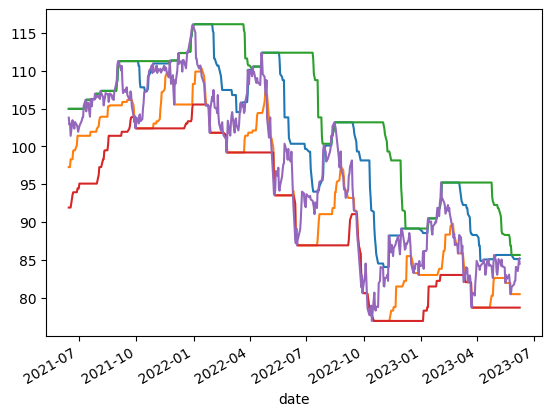

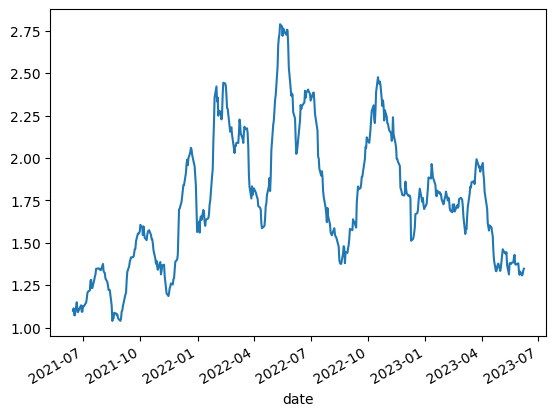

In [93]:
df['20_up_bound'] = df['close'].shift(1).rolling(20).max()
df['20_low_bound'] = df['close'].shift(1).rolling(20).min()
df['10_up_bound'] = df['close'].shift(1).rolling(10).max()
df['10_low_bound'] = df['close'].shift(1).rolling(10).min()
df['55_up_bound'] = df['close'].shift(1).rolling(55).max()
df['55_low_bound'] = df['close'].shift(1).rolling(55).min()



df = df.dropna()


df['High-Low'] = df['high'] - df['low']
df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
df['ATR'] = df['TR'].rolling(20).mean()


df1 = df[-500:].copy()
df1['20_up_bound'].plot()
df1['20_low_bound'].plot()
df1['55_up_bound'].plot()
df1['55_low_bound'].plot()
df1['close'].plot()
plt.show()

df1['ATR'].plot()
plt.show()

In [94]:
bt = backTester()
df = df.dropna()
# df = df[-1000:]
bt.set_asset(df)

upbound55 = df['20_up_bound'].to_numpy()
lowbound20 = df['20_low_bound'].to_numpy()
upbound10 = df['10_up_bound'].to_numpy()
lowbound20 = df['10_low_bound'].to_numpy()
upbound55 = df['55_up_bound'].to_numpy()
lowbound55 = df['55_low_bound'].to_numpy()
atr = df['ATR'].to_numpy()


stop_loss_arr = []
stop_loss = np.nan
tl = tradeList()
last_trade_win = False
open_trade = None



for i in range(len(bt.df)):
    
    order_quantity = 0
    order_price = 0
    n = atr[i]
    risk_unit = int(bt.portfolio_value * 0.02 / (2 * n))
    

    # no open trades
    if open_trade == None:
        # breakout from 55 day high
        if bt.high[i] > upbound55[i]:
            # print(f'--- index {i}, date: {bt.date[i]} ---')
            # print(f'high: {bt.high[i]} > long breakout: {upbound55[i]}')
            long_entry_price = upbound55[i]
            # calculate stop_loss
            stop_loss = long_entry_price - 3 * n
                
            # order price at breakout
            order_price = long_entry_price
            # order 1 unit
            order_quantity = risk_unit
            
            # open trade on record
            open_trade = trade(bt.date[i], order_price, order_quantity, type='long20')
            # print(f'entry price: {order_price}, quantity: {order_quantity}')



            

    # open trades present 
    else:
        # if open trades are long
        if open_trade.quantity > 0:
            pass
            # calculate trailing stop_loss
            stop_loss = max(stop_loss, bt.high[i] - 3.0 * n)
            # print(f'stop_loss {stop_loss}')
            # print(f'lowbound20 {lowbound20[i]}')
            # combine low bound 10 and trailing stop loss
            stop_loss = max(stop_loss, lowbound20[i])
            

            # exit trade if stop loss is triggered
            if bt.low[i] < stop_loss:
                

                # print(f'--- index {i}, date: {bt.date[i]} ---')
                # print(f'low: {bt.low[i]} < stop_loss: {stop_loss}')
                # exit price at stoploss
                order_price = stop_loss
                order_quantity = -open_trade.quantity
                    
                open_trade.close(bt.date[i], order_price)
                tl.append(open_trade)

                
                open_trade = None
                stop_loss = np.nan
    
    stop_loss_arr.append(stop_loss)
    bt.take_action(order_quantity=order_quantity, order_price=order_price)
            

df['stop_loss'] = stop_loss_arr


df['entry_price'] = np.nan
df['exit_price'] = np.nan

for t in tl.list:
    
    for i in range(len(t.entry_date)):
        df.loc[df.index == t.entry_date[i], 'entry_price'] = t.entry_price[i]
        
    df.loc[df.index == t.exit_date, 'exit_price'] = t.exit_price



end


In [95]:
print(len(bt.date))

5706


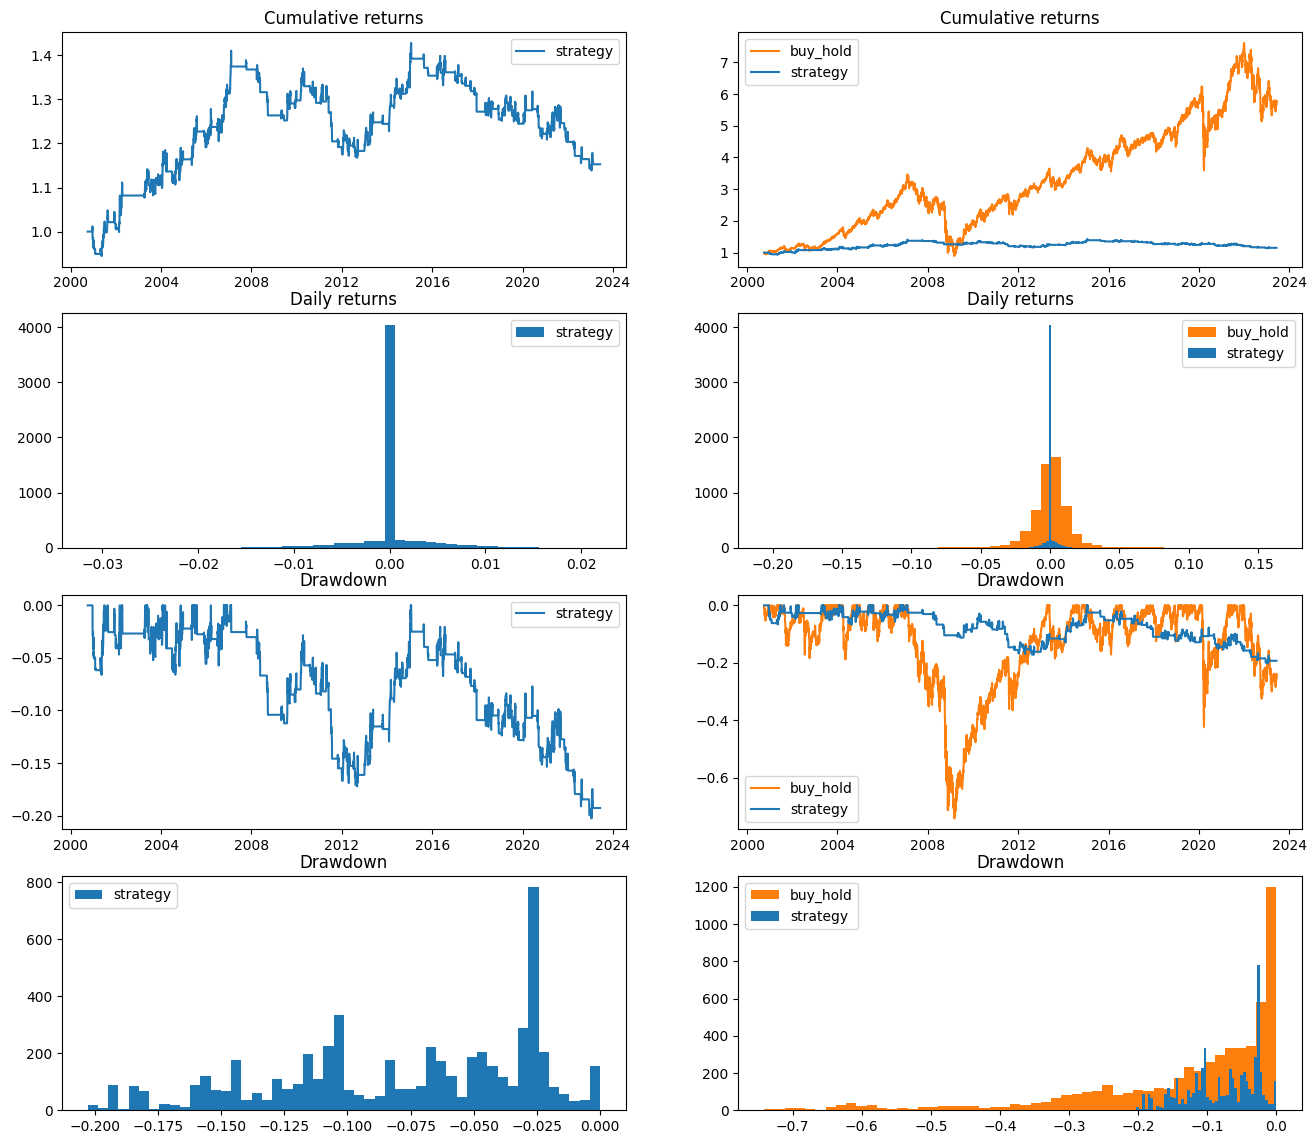

In [96]:
bt.analyse()
bt.plot_graphs()

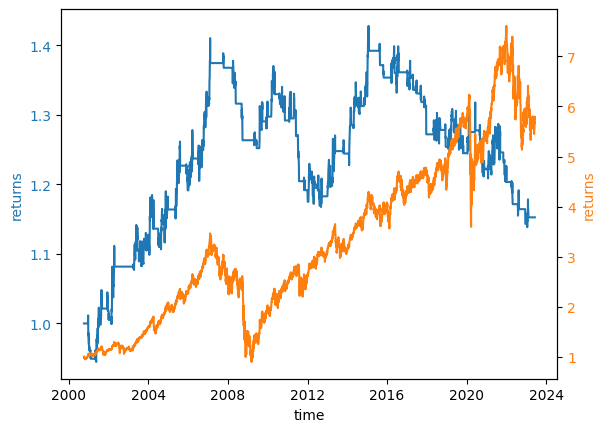

In [97]:

fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('returns', color=color)
ax1.plot(bt.date, bt.records['cum_returns'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'C1'
ax2 = ax1.twinx()
ax2.set_ylabel('returns', color=color)
ax2.plot(bt.date, bt.records['buy_hold_cum_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [98]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          0.0062859481922779015
buy_hold annual return:     0.08018344146256795
Annualised vol:             0.05989839492097942
buy_hold annual vol:        0.26940936155038847
Sharpe ratio:               0.1049435164426459
buy_hold Sharpe ratio:      0.2976267825332083


In [99]:
tl.analyse(bt.df)
tl.stats

{'num_wins': 61,
 'num_loss': 82,
 'win_rate': 0.42657342657342656,
 'profit_total': 152696.7175928103,
 'profit_mean': 1067.8092139357364,
 'returns_mean': -0.0002700486122638575,
 'returns_std': 0.024216079881100024,
 'time_in_trade_mean': 16.902097902097903,
 'time_in_trade_std': 10.582549205200442,
 'capital_at_risk_mean': 1007292.189775827,
 'win_returns_mean': 0.021741222202711106,
 'win_returns_std': 0.016330601017933037,
 'win_profit_mean': 21480.826860656114,
 'win_time_in_trade_mean': 25.19672131147541,
 'win_time_in_trade_std': 8.82764534881027,
 'loss_returns_mean': -0.016644286657550113,
 'loss_returns_std': 0.01393564355372359,
 'loss_profit_mean': -14117.484401307467,
 'loss_time_in_trade_mean': 10.731707317073171,
 'loss_time_in_trade_std': 6.9460865267239456}

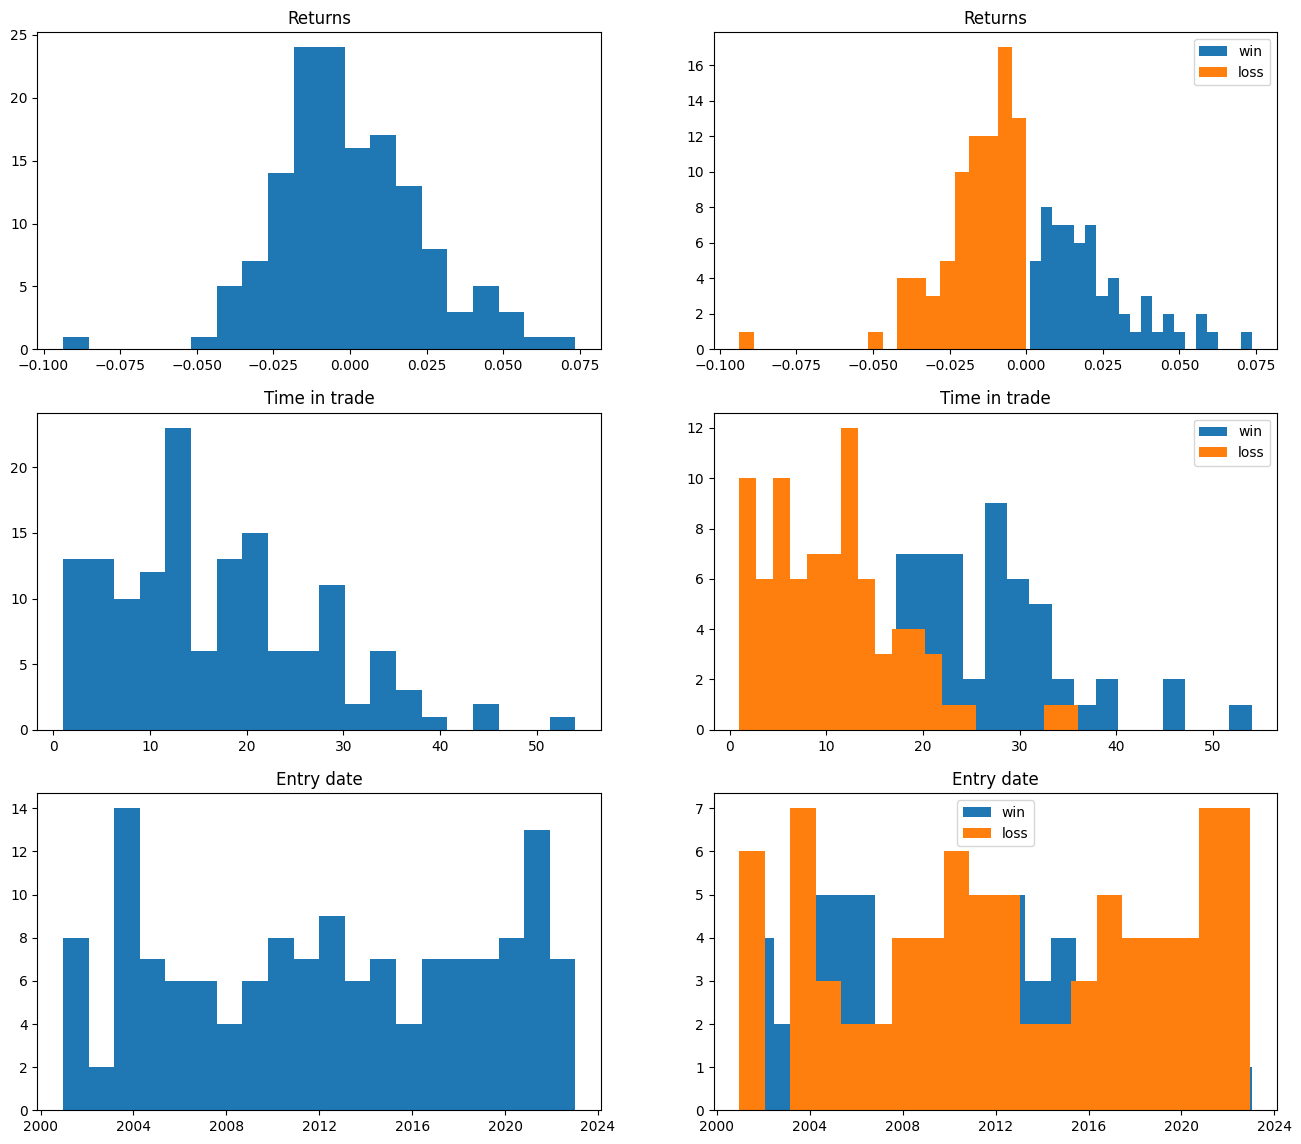

In [100]:
tl.plot_graphs()

trade 0
entry: [37.875]
cost_basis: 37.875
exit: 37.45874900817871
returns: -0.010990125196601804
3


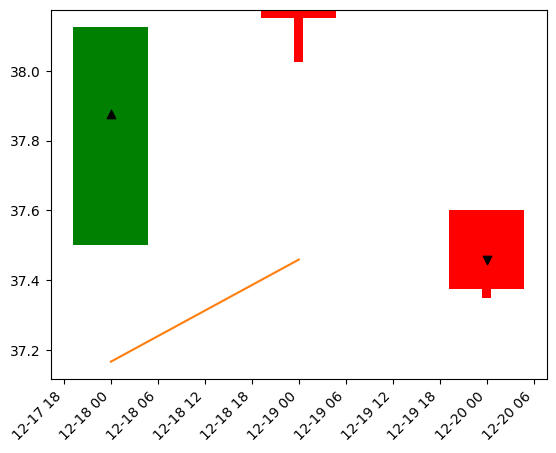

trade 1
entry: [38.150001525878906]
cost_basis: 38.150001525878906
exit: 37.29999923706055
returns: -0.022280530925844488
9


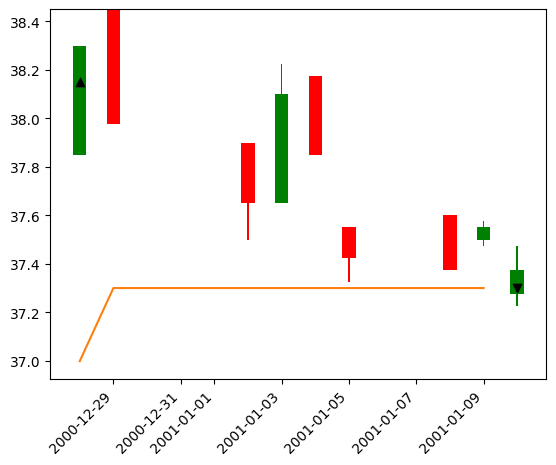

trade 2
entry: [38.29999923706055]
cost_basis: 38.29999923706055
exit: 38.0
returns: -0.007832878408265244
6


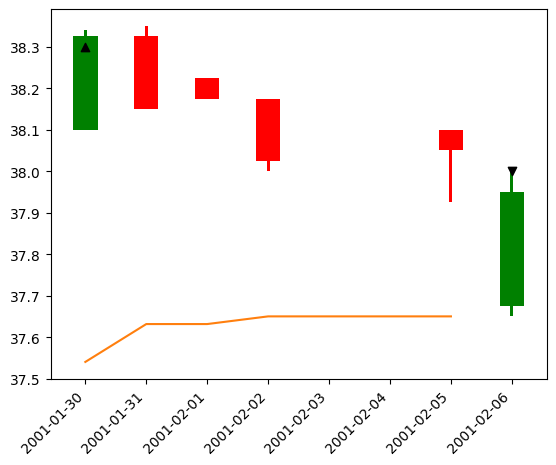

trade 3
entry: [38.275001525878906]
cost_basis: 38.275001525878906
exit: 38.150001525878906
returns: -0.0032658391905088144
11


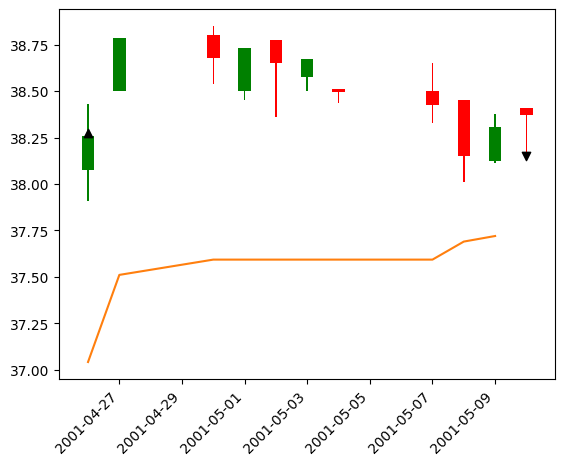

trade 4
entry: [38.78499984741211]
cost_basis: 38.78499984741211
exit: 40.65150127410889
returns: 0.048124311822610955
37


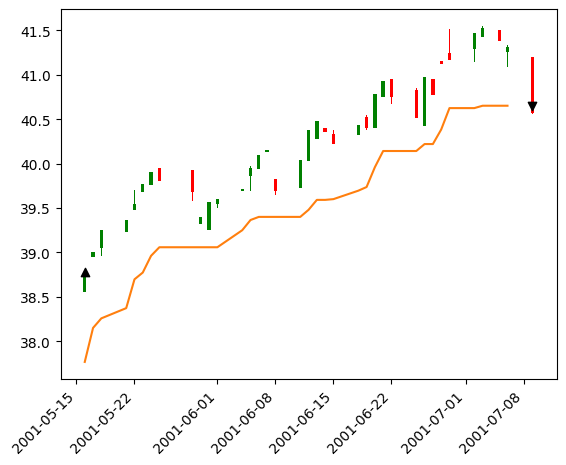

trade 5
entry: [41.525001525878906]
cost_basis: 41.525001525878906
exit: 42.21550025939941
returns: 0.016628505915651293
14


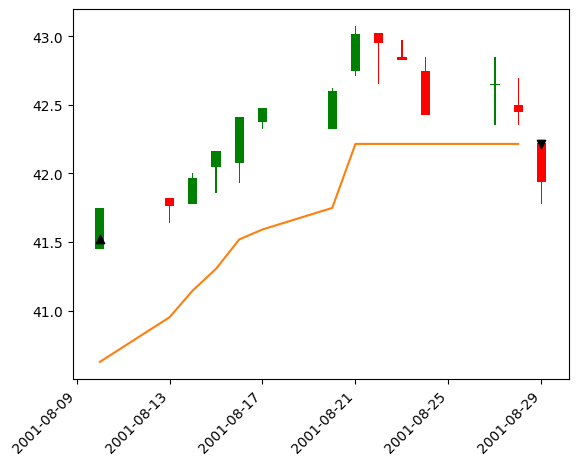

trade 6
entry: [39.650001525878906]
cost_basis: 39.650001525878906
exit: 39.55500030517578
returns: -0.002395995385803939
9


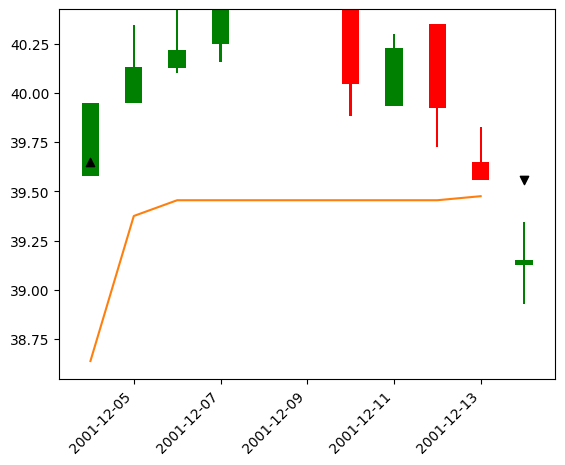

trade 7
entry: [40.41999816894531]
cost_basis: 40.41999816894531
exit: 39.900001525878906
returns: -0.012864835888733902
9


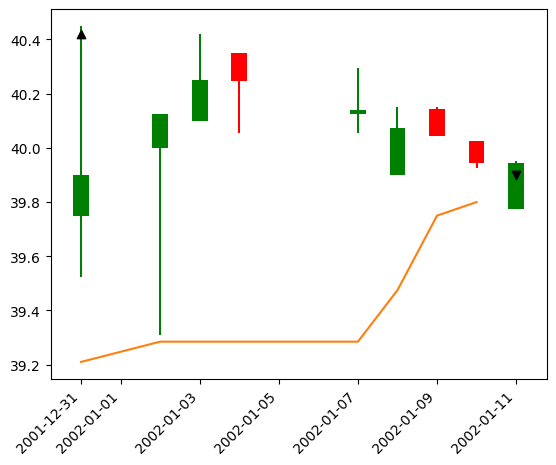

trade 8
entry: [40.41999816894531]
cost_basis: 40.41999816894531
exit: 41.56924686431885
returns: 0.02843267559216528
16


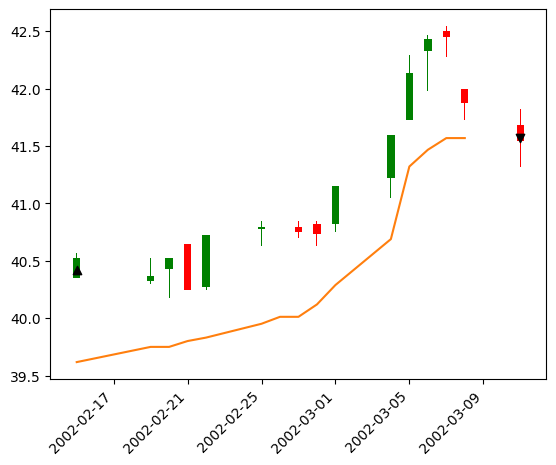

trade 9
entry: [42.45000076293945]
cost_basis: 42.45000076293945
exit: 43.6322509765625
returns: 0.027850416781504544
18


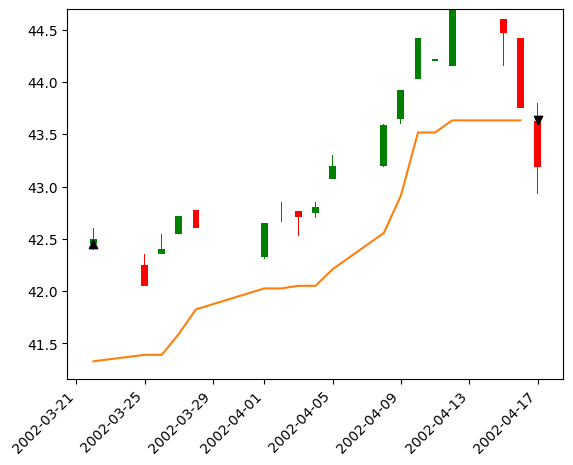

trade 10
entry: [39.20000076293945]
cost_basis: 39.20000076293945
exit: 39.70500183105469
returns: 0.012882680058329835
21


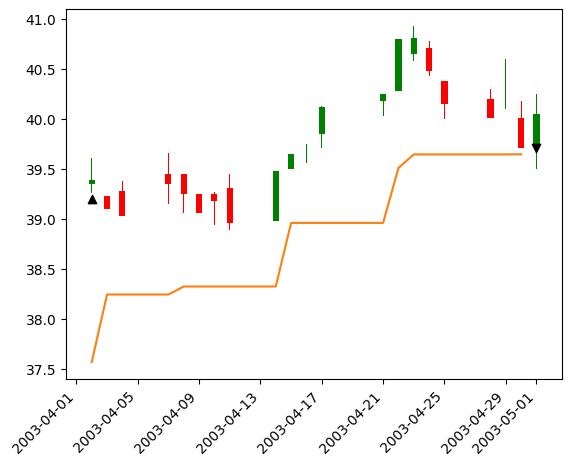

trade 11
entry: [40.810001373291016]
cost_basis: 40.810001373291016
exit: 41.65999984741211
returns: 0.020828190284683343
18


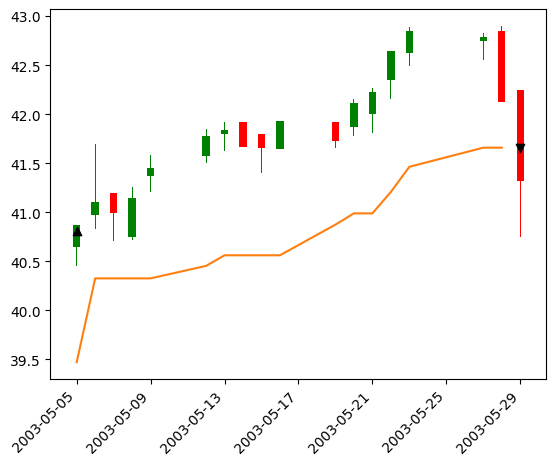

trade 12
entry: [42.845001220703125]
cost_basis: 42.845001220703125
exit: 42.46874732971191
returns: -0.008781745367518058
8


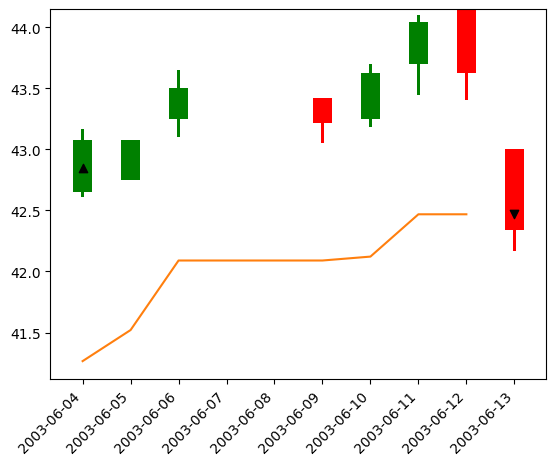

trade 13
entry: [44.04499816894531]
cost_basis: 44.04499816894531
exit: 43.994998931884766
returns: -0.0011351853590449166
27


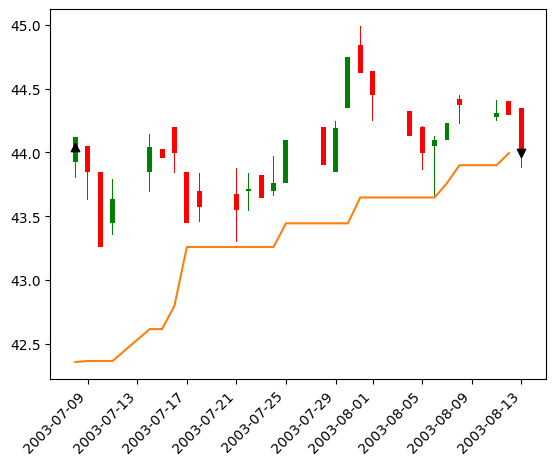

trade 14
entry: [44.744998931884766]
cost_basis: 44.744998931884766
exit: 44.025001525878906
returns: -0.016091125783730828
3


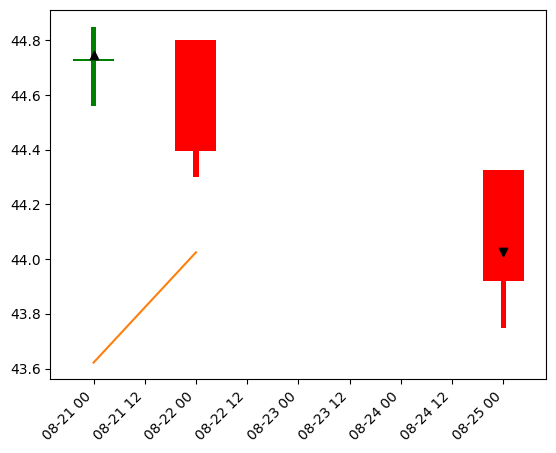

trade 15
entry: [44.744998931884766]
cost_basis: 44.744998931884766
exit: 44.92299900054932
returns: 0.0039780997410575735
12


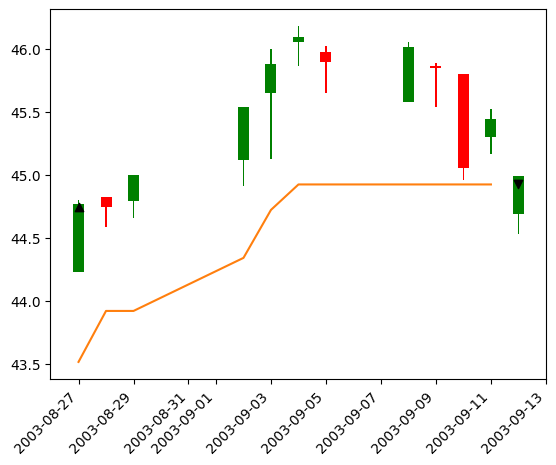

trade 16
entry: [46.09000015258789]
cost_basis: 46.09000015258789
exit: 47.11000061035156
returns: 0.02213062387474087
14


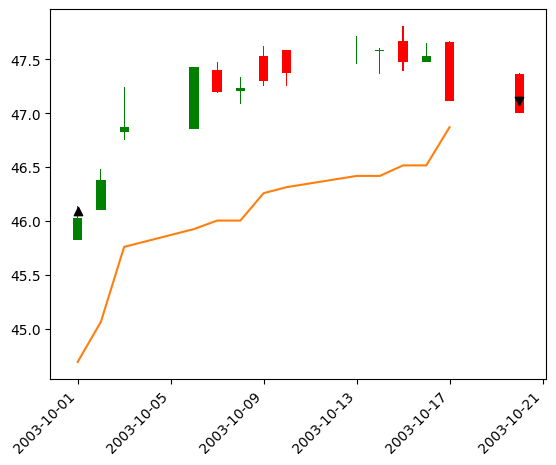

trade 17
entry: [47.584999084472656]
cost_basis: 47.584999084472656
exit: 47.375
returns: -0.004413136251192669
10


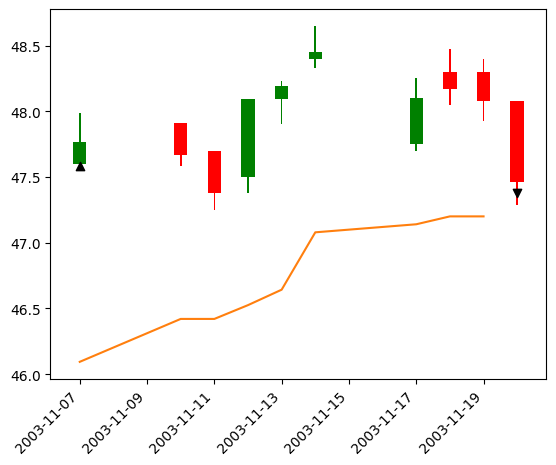

trade 18
entry: [48.45000076293945]
cost_basis: 48.45000076293945
exit: 48.72499847412109
returns: 0.005675907262151908
13


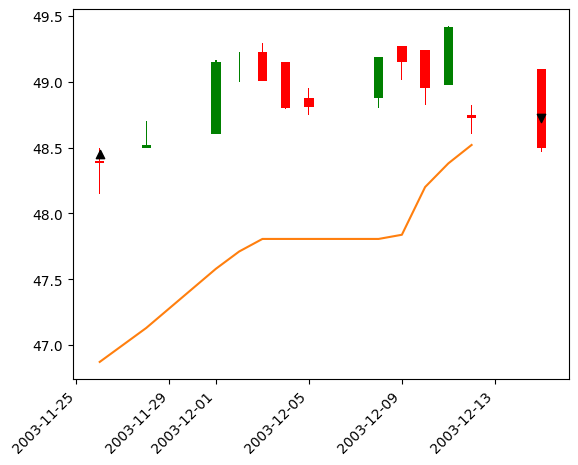

trade 19
entry: [49.41999816894531]
cost_basis: 49.41999816894531
exit: 49.380001068115234
returns: -0.0008093302774586427
12


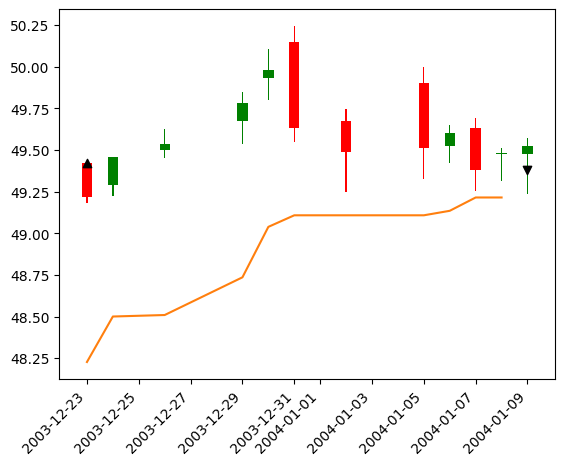

trade 20
entry: [49.97999954223633]
cost_basis: 49.97999954223633
exit: 51.4515007019043
returns: 0.029441800182980385
15


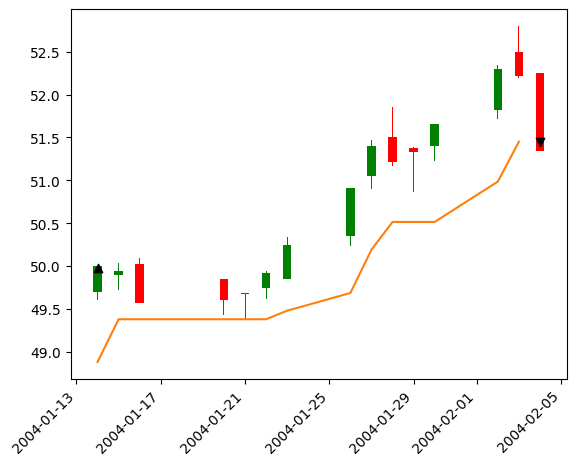

trade 21
entry: [52.29999923706055]
cost_basis: 52.29999923706055
exit: 52.22499847412109
returns: -0.0014340490254981415
11


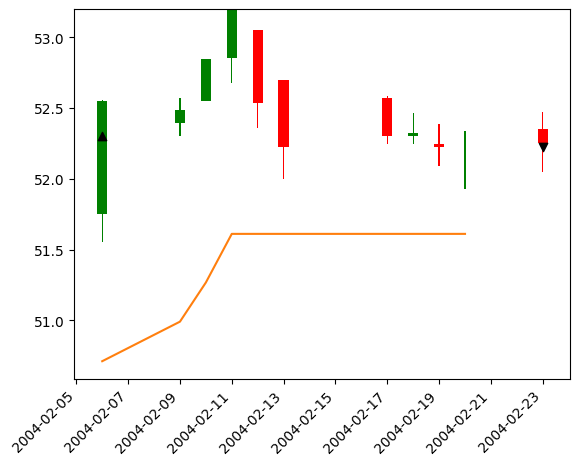

trade 22
entry: [53.20000076293945]
cost_basis: 53.20000076293945
exit: 53.44024868011474
returns: 0.004515938228005663
9


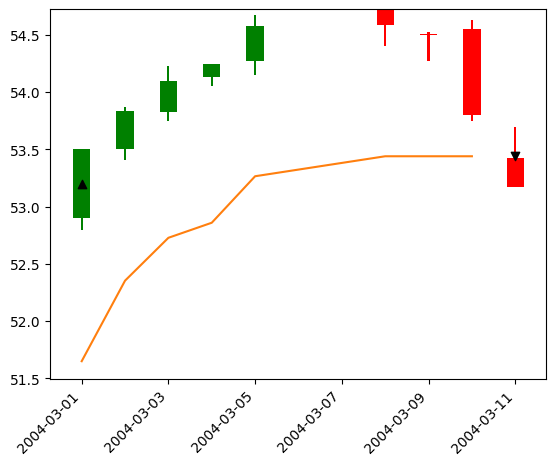

trade 23
entry: [54.584999084472656]
cost_basis: 54.584999084472656
exit: 53.625
returns: -0.017587232766771984
13


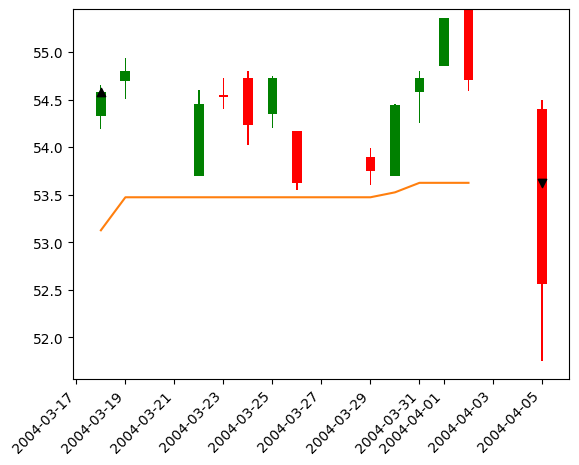

trade 24
entry: [51.25]
cost_basis: 51.25
exit: 49.875
returns: -0.026829268292682926
3


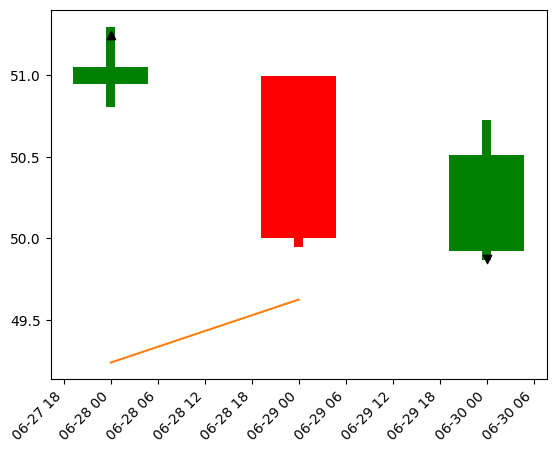

trade 25
entry: [51.244998931884766]
cost_basis: 51.244998931884766
exit: 51.05500030517578
returns: -0.0037076520766744863
14


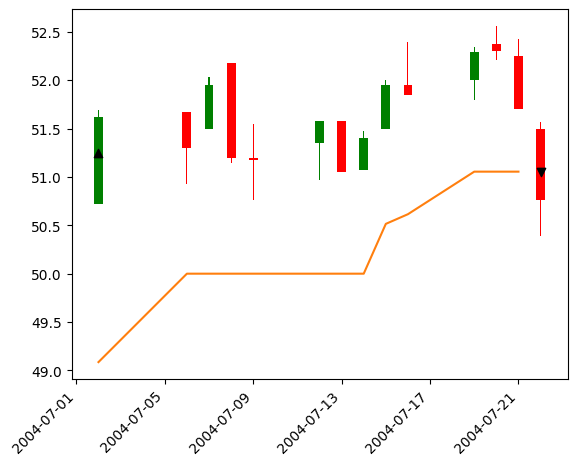

trade 26
entry: [52.29999923706055]
cost_basis: 52.29999923706055
exit: 54.40999984741211
returns: 0.04034418051877112
19


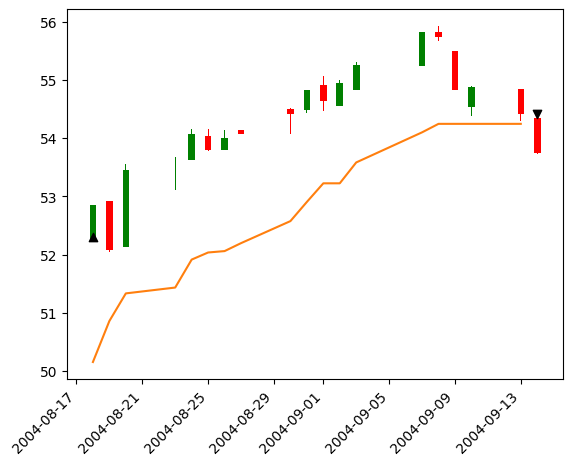

trade 27
entry: [55.82500076293945]
cost_basis: 55.82500076293945
exit: 55.19299945831298
returns: -0.011321115915613874
4


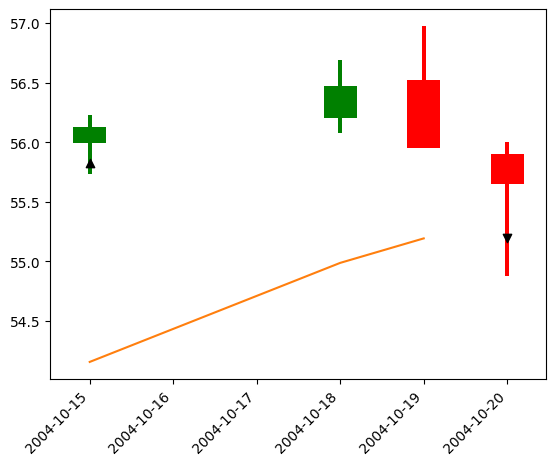

trade 28
entry: [56.47499847412109]
cost_basis: 56.47499847412109
exit: 57.91000022888184
returns: 0.025409504976229888
20


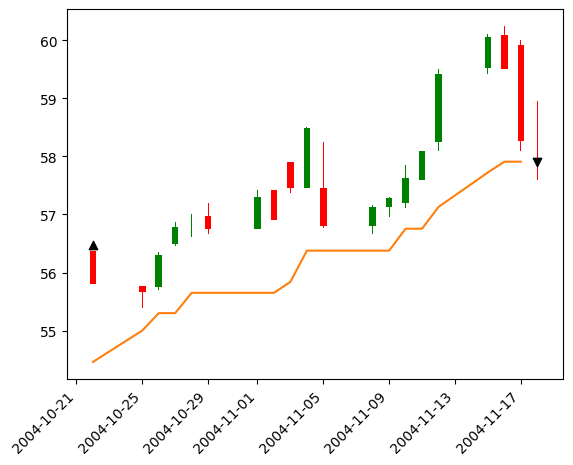

trade 29
entry: [60.060001373291016]
cost_basis: 60.060001373291016
exit: 60.84999847412109
returns: 0.01315346458152741
17


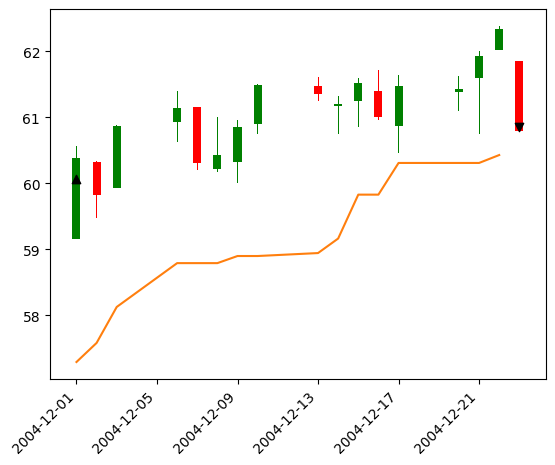

trade 30
entry: [60.400001525878906]
cost_basis: 60.400001525878906
exit: 63.34000015258789
returns: 0.04867547272245211
33


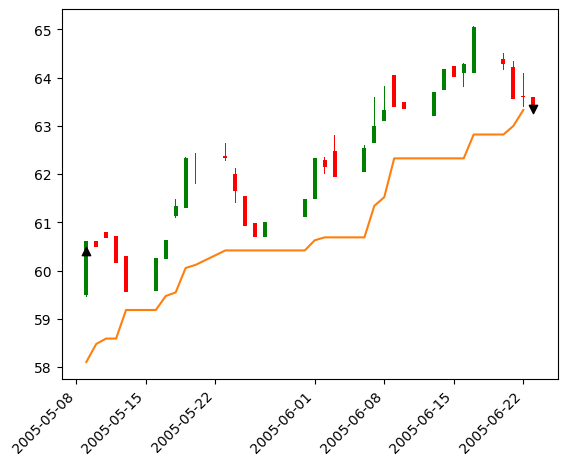

trade 31
entry: [65.04000091552734]
cost_basis: 65.04000091552734
exit: 66.19000244140625
returns: 0.017681450026000235
24


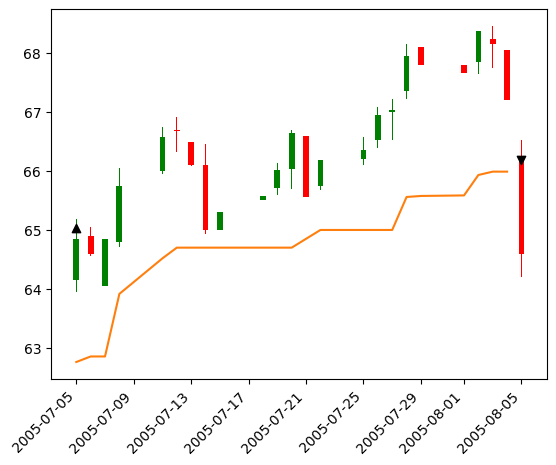

trade 32
entry: [66.26000213623047]
cost_basis: 66.26000213623047
exit: 65.25
returns: -0.015243013940052489
10


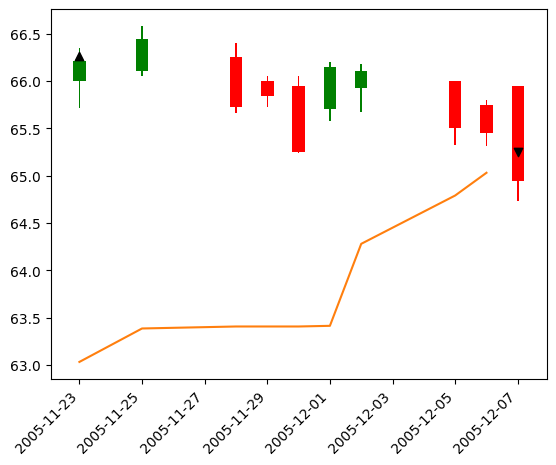

trade 33
entry: [66.44000244140625]
cost_basis: 66.44000244140625
exit: 64.94000244140625
returns: -0.022576760157750703
5


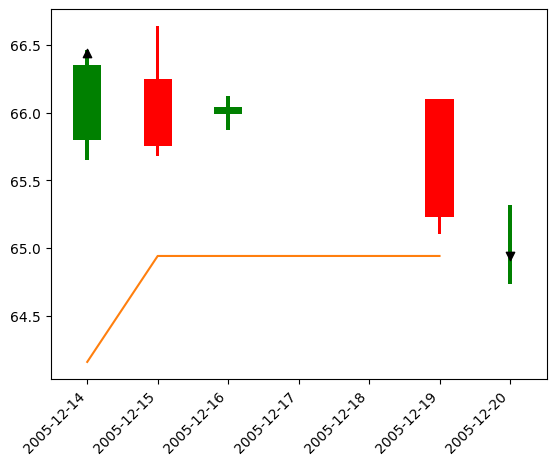

trade 34
entry: [66.44000244140625]
cost_basis: 66.44000244140625
exit: 67.69999694824219
returns: 0.01896439585394556
23


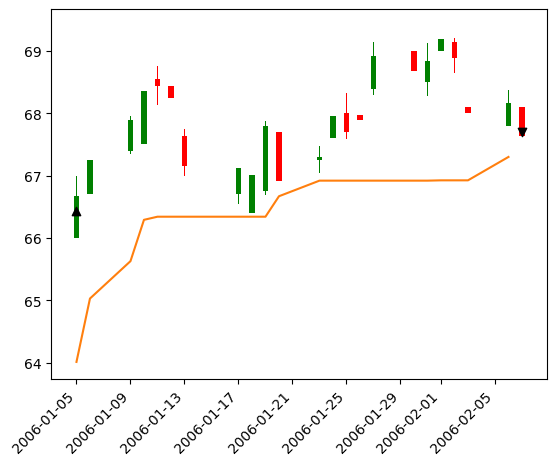

trade 35
entry: [69.19000244140625]
cost_basis: 69.19000244140625
exit: 69.93000030517578
returns: 0.010695155913546911
14


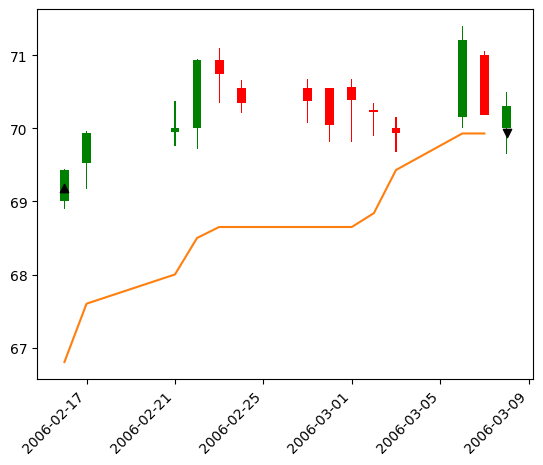

trade 36
entry: [71.20999908447266]
cost_basis: 71.20999908447266
exit: 72.26449508666992
returns: 0.014808257488479611
13


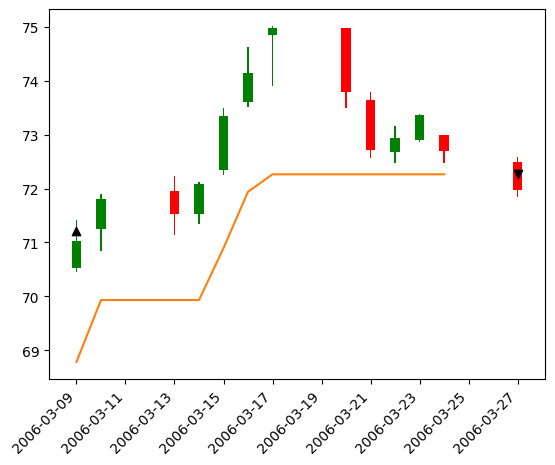

trade 37
entry: [71.91000366210938]
cost_basis: 71.91000366210938
exit: 71.25
returns: -0.009178189799719651
11


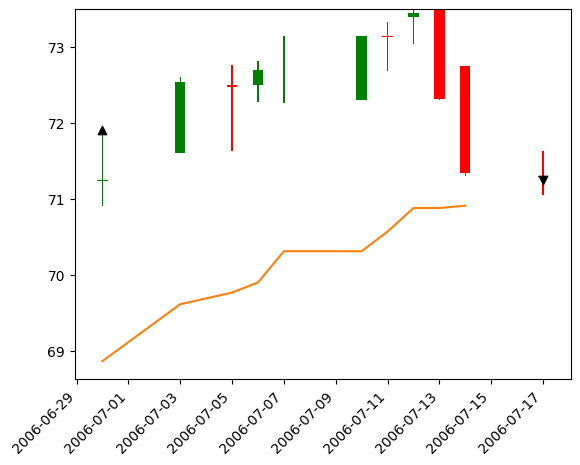

trade 38
entry: [73.44999694824219]
cost_basis: 73.44999694824219
exit: 73.0999984741211
returns: -0.004765125781662404
16


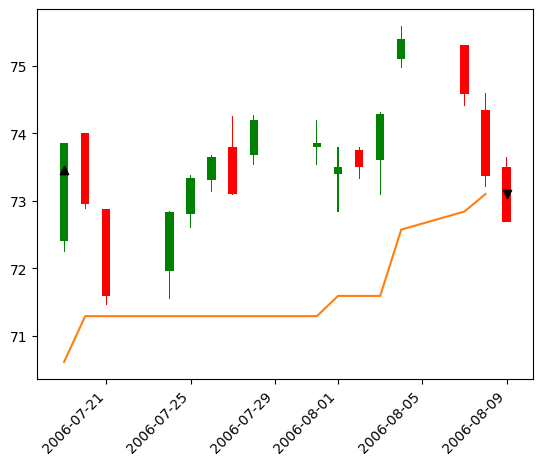

trade 39
entry: [75.4000015258789]
cost_basis: 75.4000015258789
exit: 77.19999694824219
returns: 0.02387261785061747
21


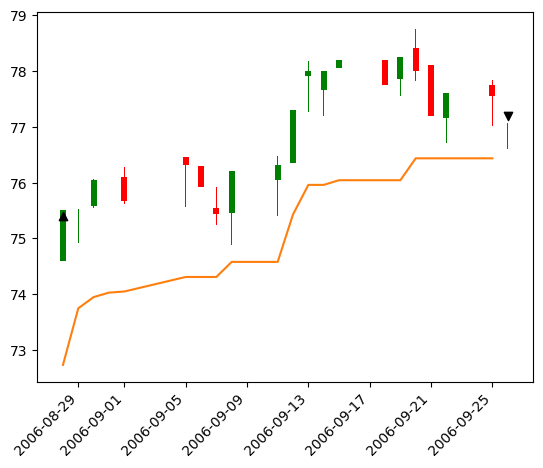

trade 40
entry: [78.25]
cost_basis: 78.25
exit: 80.6500015258789
returns: 0.030670946017621804
22


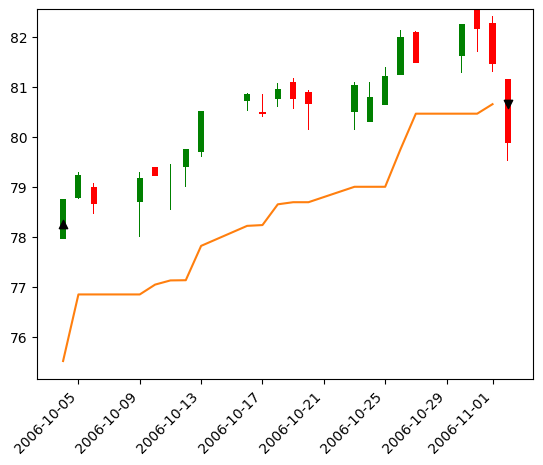

trade 41
entry: [82.25]
cost_basis: 82.25
exit: 85.0
returns: 0.03343465045592705
17


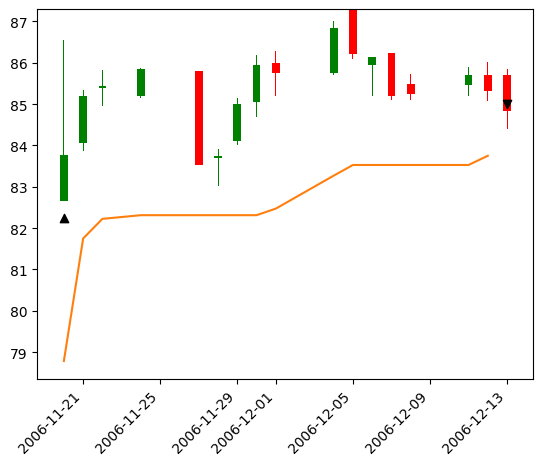

trade 42
entry: [86.8499984741211]
cost_basis: 86.8499984741211
exit: 91.72900390624999
returns: 0.056177380746675554
19


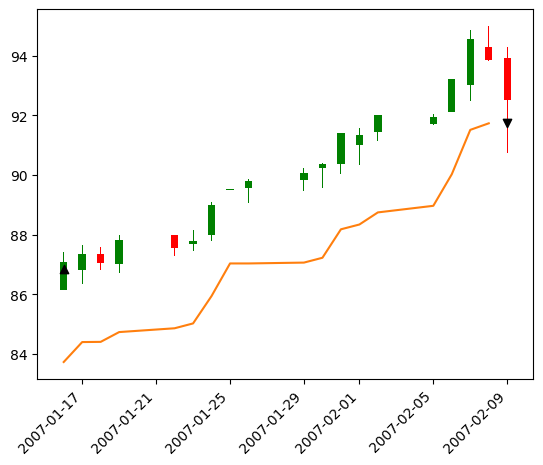

trade 43
entry: [79.23999786376953]
cost_basis: 79.23999786376953
exit: 78.5
returns: -0.009338691112053606
10


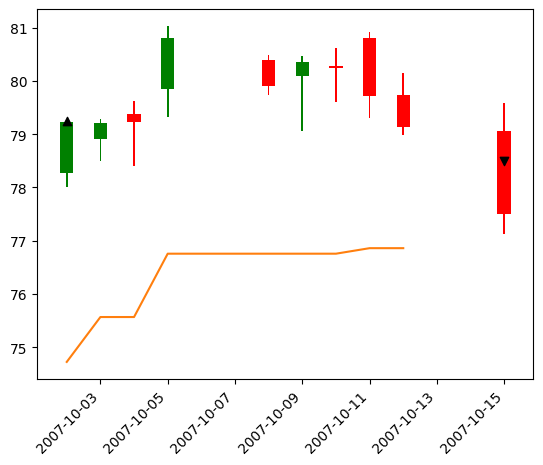

trade 44
entry: [68.33000183105469]
cost_basis: 68.33000183105469
exit: 65.70999908447266
returns: -0.03834337298951
17


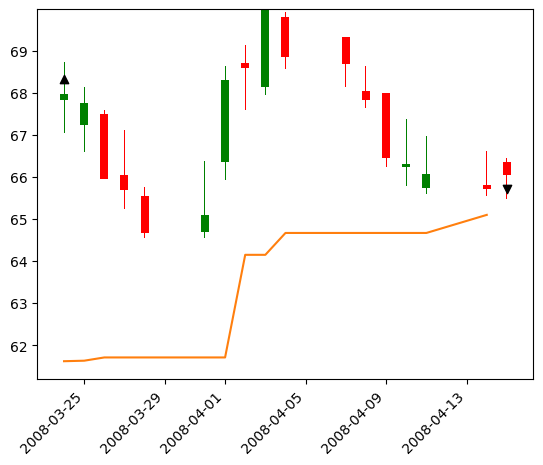

trade 45
entry: [69.98999786376953]
cost_basis: 69.98999786376953
exit: 68.87999725341797
returns: -0.015859417691540704
14


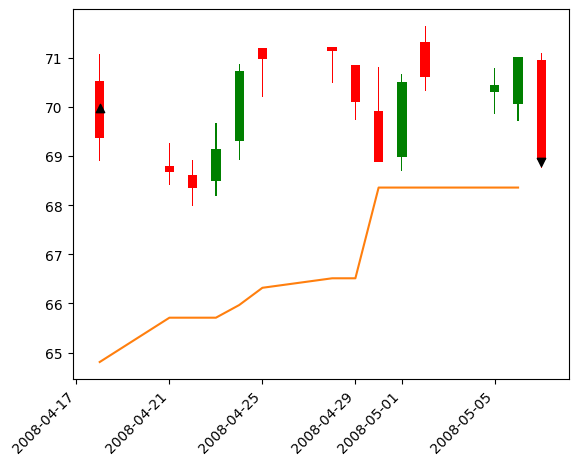

trade 46
entry: [71.13999938964844]
cost_basis: 71.13999938964844
exit: 68.4000015258789
returns: -0.03851557333817222
6


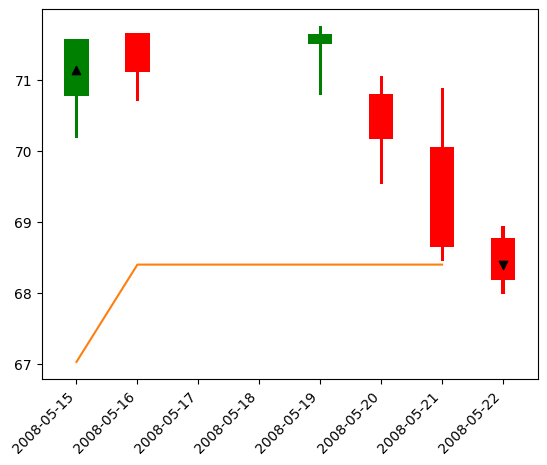

trade 47
entry: [66.23999786376953]
cost_basis: 66.23999786376953
exit: 63.060001373291016
returns: -0.04800719494313026
6


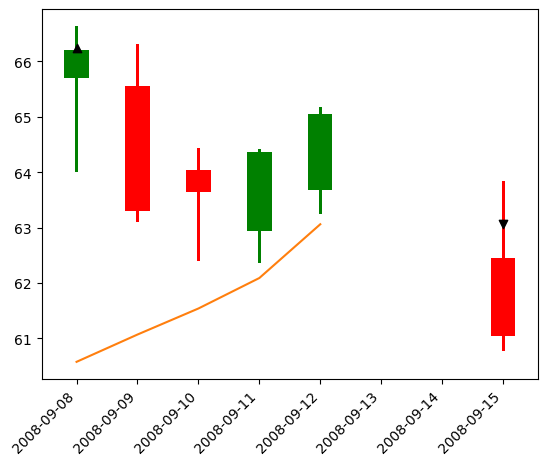

trade 48
entry: [66.19999694824219]
cost_basis: 66.19999694824219
exit: 60.0
returns: -0.09365554734223921
4


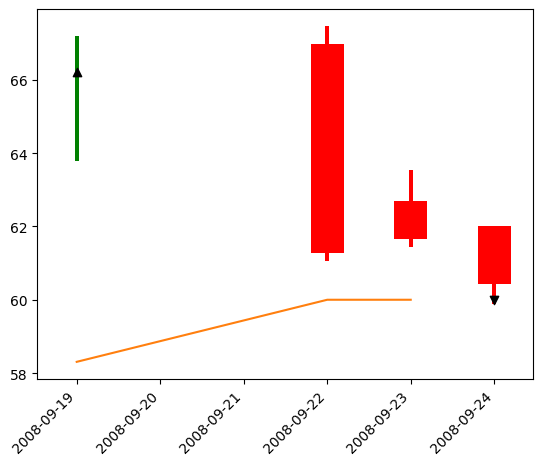

trade 49
entry: [32.720001220703125]
cost_basis: 32.720001220703125
exit: 31.8799991607666
returns: -0.025672433636861353
14


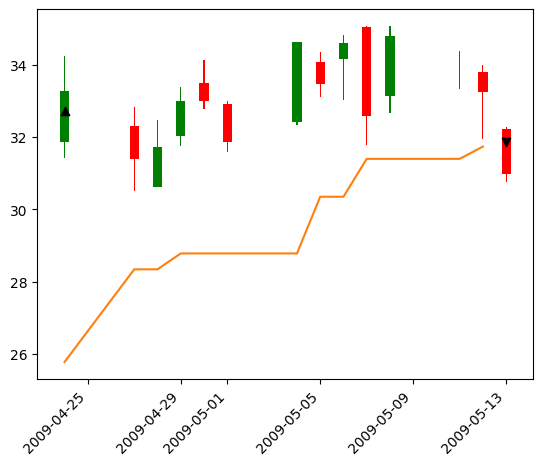

trade 50
entry: [34.810001373291016]
cost_basis: 34.810001373291016
exit: 33.7400016784668
returns: -0.030738283614237576
10


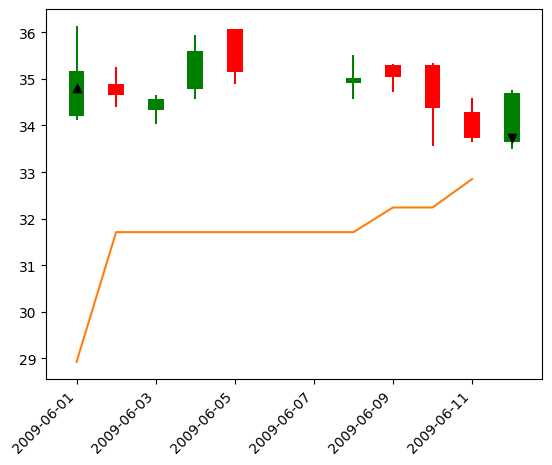

trade 51
entry: [35.59000015258789]
cost_basis: 35.59000015258789
exit: 38.20849800109863
returns: 0.07357397688351347
13


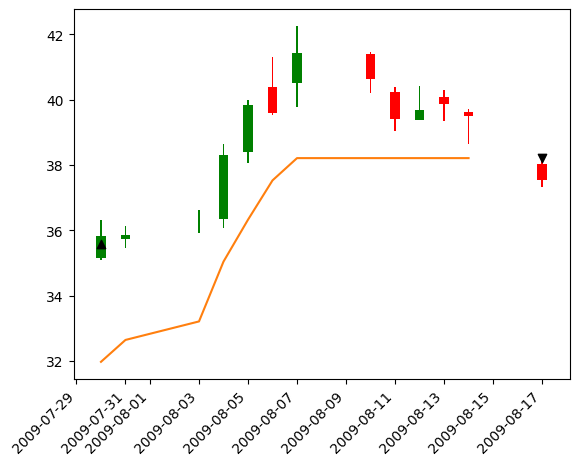

trade 52
entry: [41.43999862670898]
cost_basis: 41.43999862670898
exit: 42.497001075744635
returns: 0.025506816700384644
11


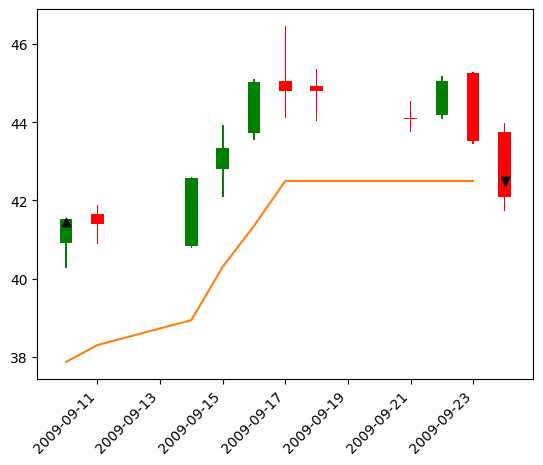

trade 53
entry: [45.040000915527344]
cost_basis: 45.040000915527344
exit: 45.61000061035156
returns: 0.012655410373842019
22


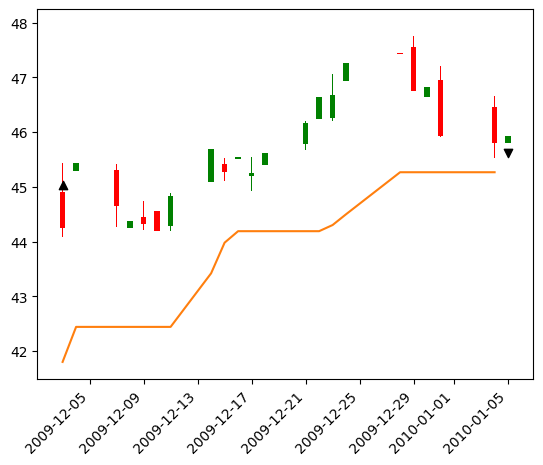

trade 54
entry: [47.43000030517578]
cost_basis: 47.43000030517578
exit: 50.11000061035156
returns: 0.05650432822964429
18


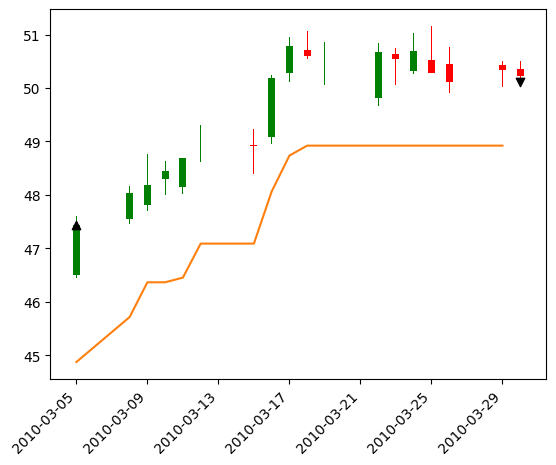

trade 55
entry: [50.790000915527344]
cost_basis: 50.790000915527344
exit: 50.64150104522705
returns: -0.002923801292054962
10


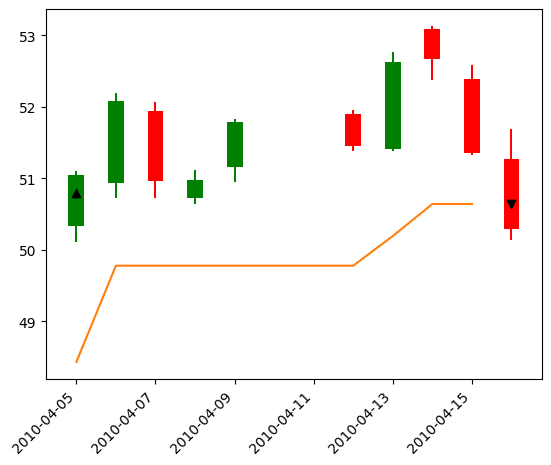

trade 56
entry: [52.66999816894531]
cost_basis: 52.66999816894531
exit: 52.22999954223633
returns: -0.008353875868718207
10


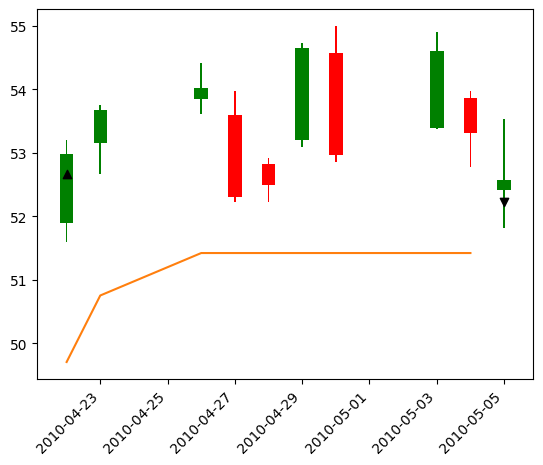

trade 57
entry: [53.09000015258789]
cost_basis: 53.09000015258789
exit: 51.470001220703125
returns: -0.030514200927268188
8


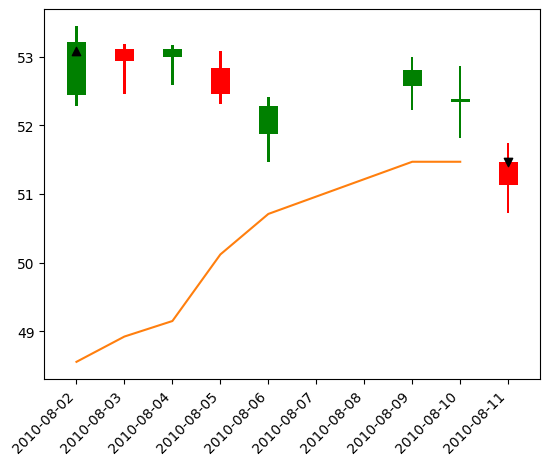

trade 58
entry: [53.220001220703125]
cost_basis: 53.220001220703125
exit: 52.83000183105469
returns: -0.007328060516780367
15


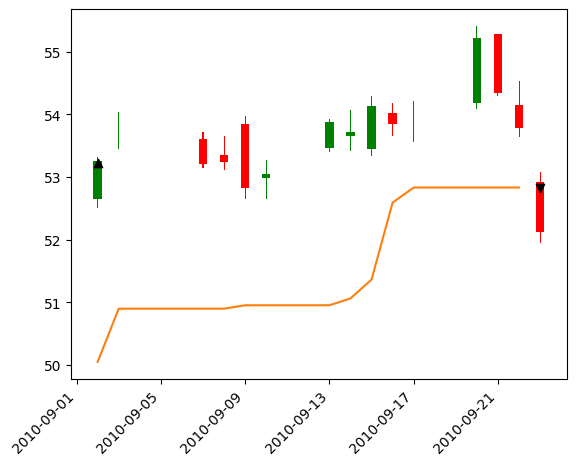

trade 59
entry: [55.209999084472656]
cost_basis: 55.209999084472656
exit: 54.77000045776367
returns: -0.007969545988142033
12


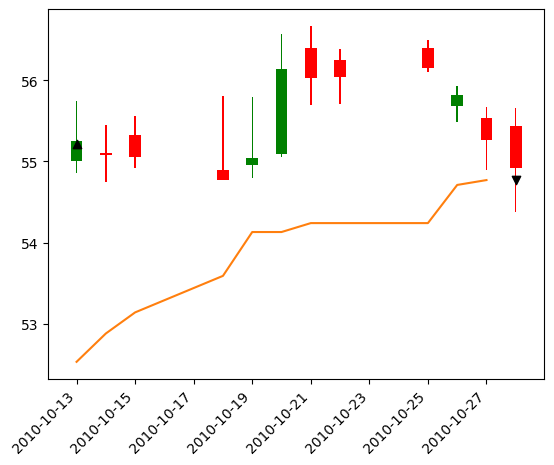

trade 60
entry: [56.150001525878906]
cost_basis: 56.150001525878906
exit: 55.36300106048584
returns: -0.01401603640260533
4


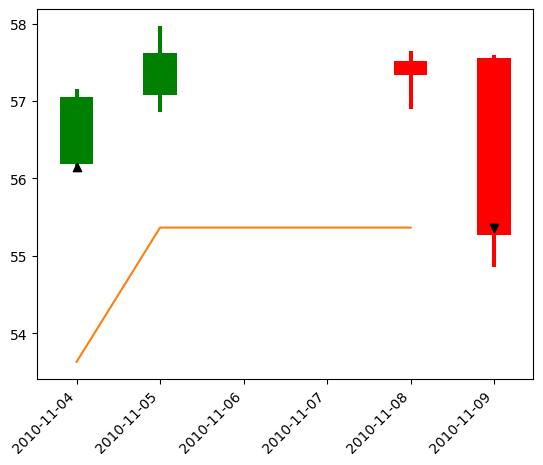

trade 61
entry: [57.38999938964844]
cost_basis: 57.38999938964844
exit: 58.65999984741211
returns: 0.022129299028930547
19


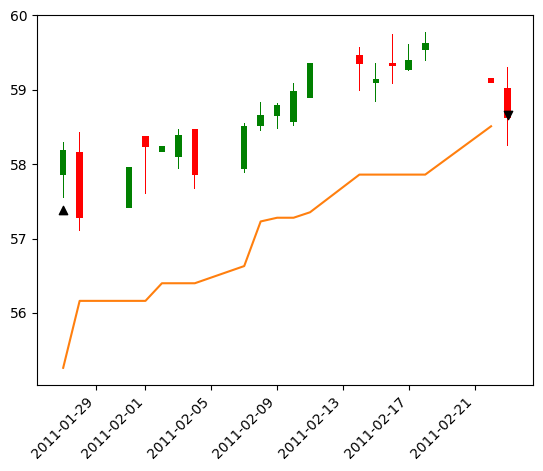

trade 62
entry: [59.630001068115234]
cost_basis: 59.630001068115234
exit: 58.5564998626709
returns: -0.018002703106077073
3


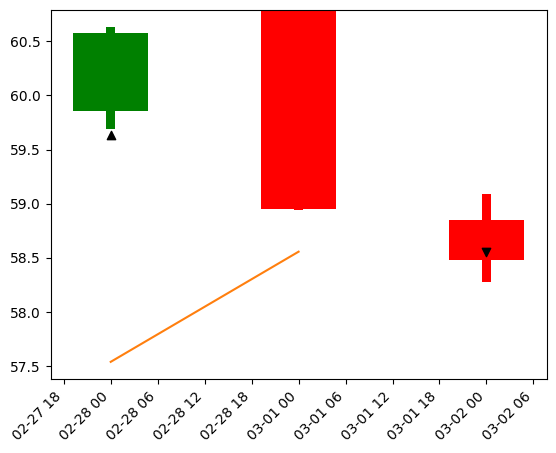

trade 63
entry: [60.58000183105469]
cost_basis: 60.58000183105469
exit: 60.93000030517578
returns: 0.005777458955798126
12


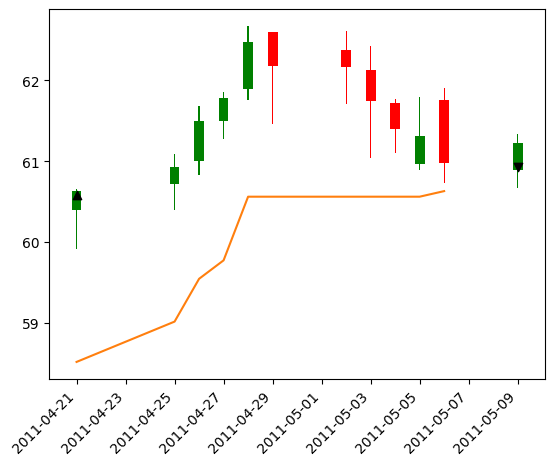

trade 64
entry: [62.470001220703125]
cost_basis: 62.470001220703125
exit: 60.38999938964844
returns: -0.03329601073171351
4


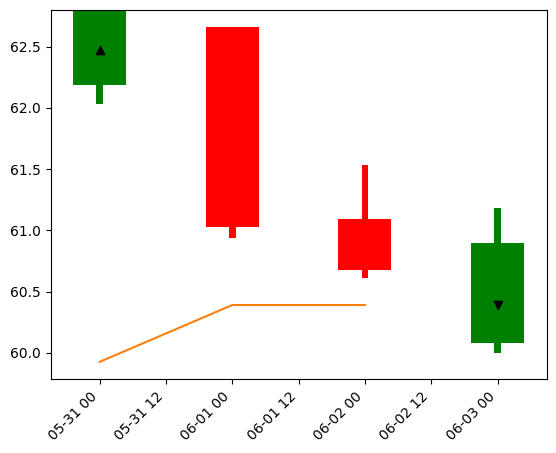

trade 65
entry: [62.79999923706055]
cost_basis: 62.79999923706055
exit: 60.52999877929688
returns: -0.03614650454365063
8


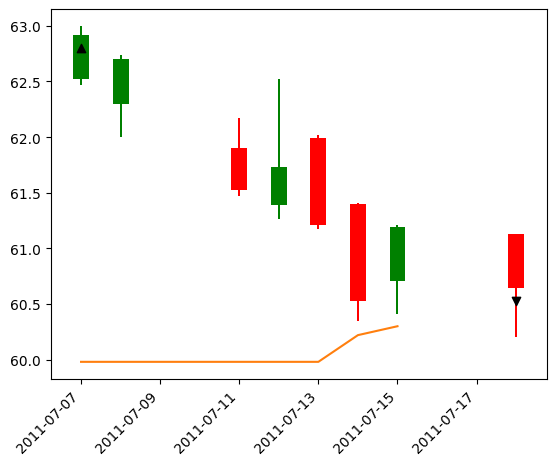

trade 66
entry: [62.91999816894531]
cost_basis: 62.91999816894531
exit: 60.52999877929688
returns: -0.037984733935164584
4


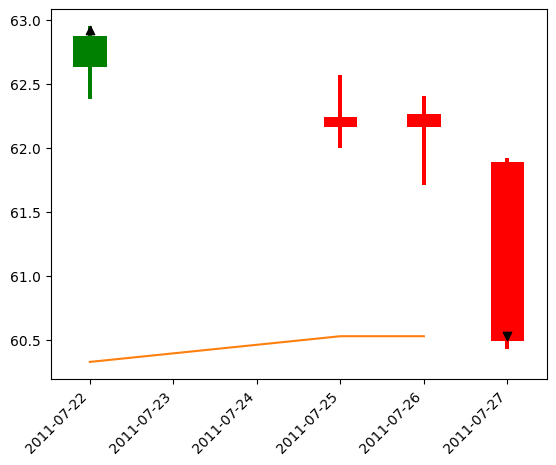

trade 67
entry: [57.220001220703125]
cost_basis: 57.220001220703125
exit: 55.310001373291016
returns: -0.03337993370613632
10


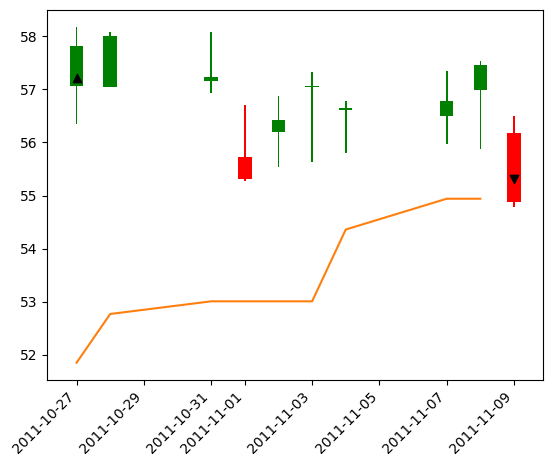

trade 68
entry: [58.0]
cost_basis: 58.0
exit: 56.52000045776367
returns: -0.025517233486833244
3


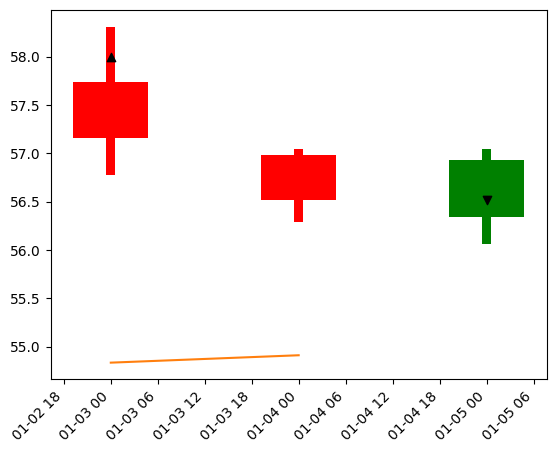

trade 69
entry: [58.0]
cost_basis: 58.0
exit: 60.560001373291016
returns: 0.04413795471191406
21


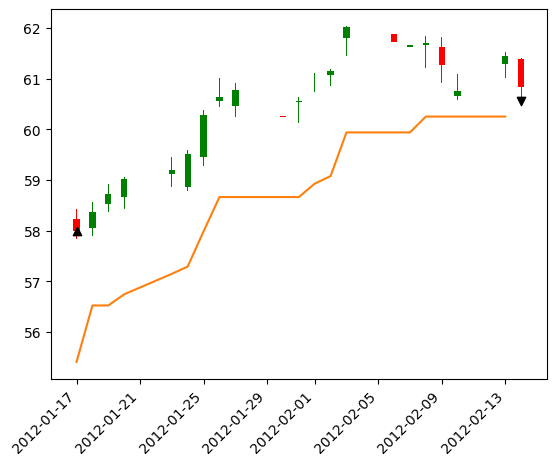

trade 70
entry: [62.02000045776367]
cost_basis: 62.02000045776367
exit: 61.540000915527344
returns: -0.007739431452652331
12


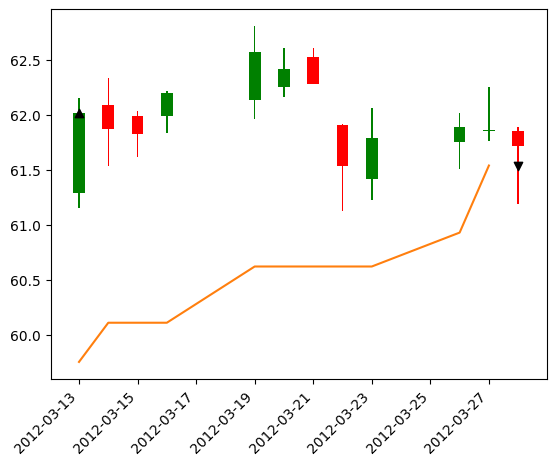

trade 71
entry: [62.56999969482422]
cost_basis: 62.56999969482422
exit: 61.540000915527344
returns: -0.016461543620273925
3


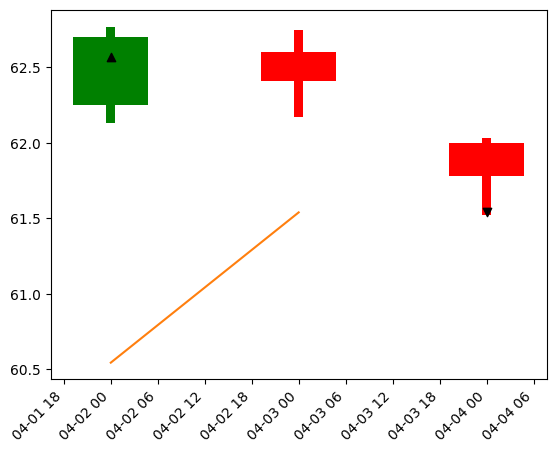

trade 72
entry: [62.70000076293945]
cost_basis: 62.70000076293945
exit: 63.41999816894531
returns: 0.011483212077270556
14


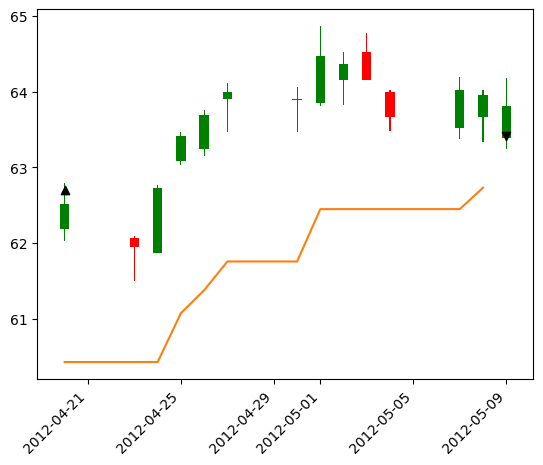

trade 73
entry: [64.47000122070312]
cost_basis: 64.47000122070312
exit: 64.12999725341797
returns: -0.005273832183145227
15


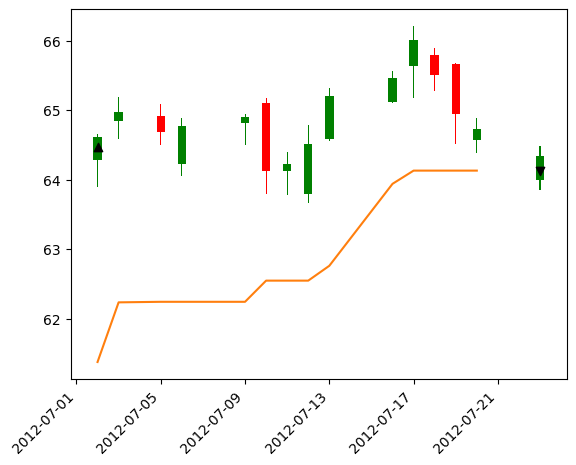

trade 74
entry: [66.01000213623047]
cost_basis: 66.01000213623047
exit: 64.52999877929688
returns: -0.022420895455800543
7


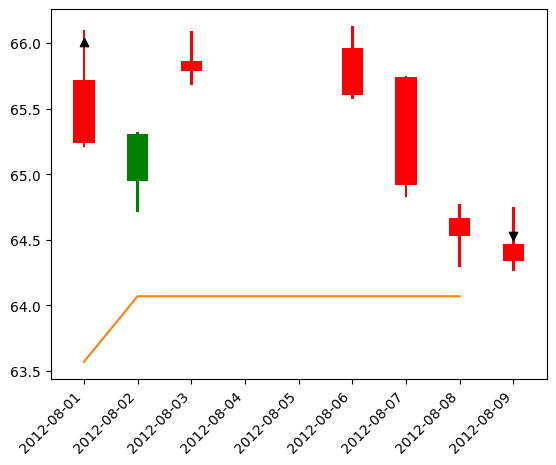

trade 75
entry: [66.01000213623047]
cost_basis: 66.01000213623047
exit: 66.62650108337402
returns: 0.009339477763858168
12


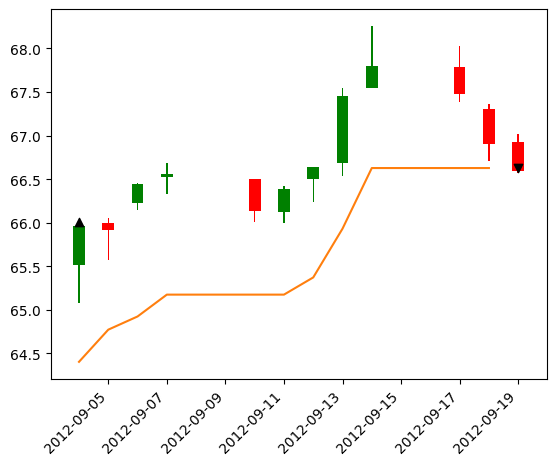

trade 76
entry: [65.38999938964844]
cost_basis: 65.38999938964844
exit: 67.2699966430664
returns: 0.02875053174745222
25


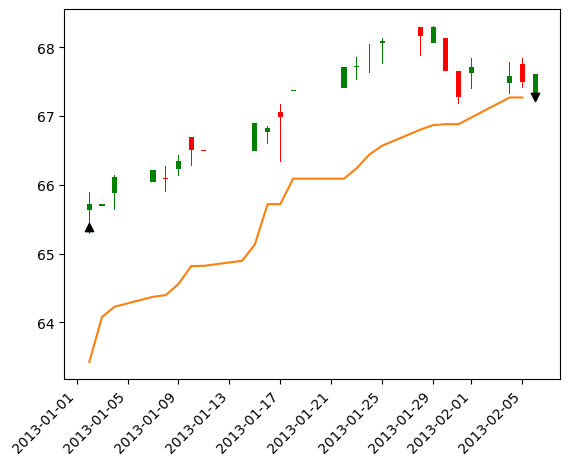

trade 77
entry: [68.29000091552734]
cost_basis: 68.29000091552734
exit: 67.46849784851074
returns: -0.012029624483865239
7


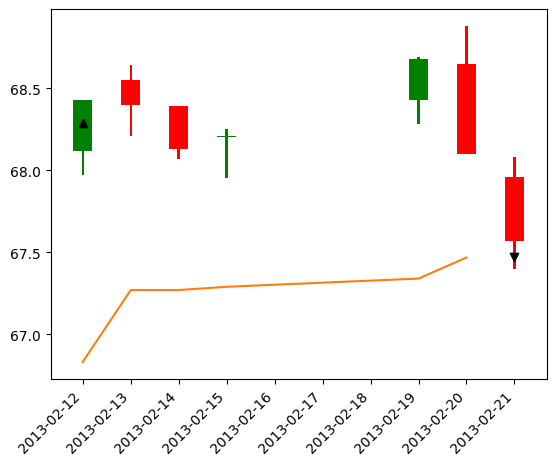

trade 78
entry: [68.68000030517578]
cost_basis: 68.68000030517578
exit: 68.76000213623047
returns: 0.0011648490200815928
11


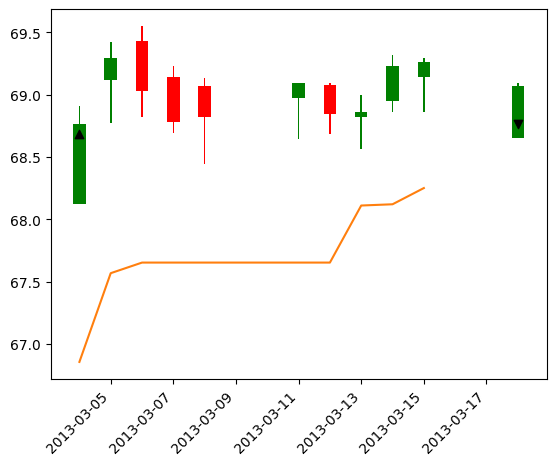

trade 79
entry: [69.29000091552734]
cost_basis: 69.29000091552734
exit: 70.62900199890137
returns: 0.019324593241186832
14


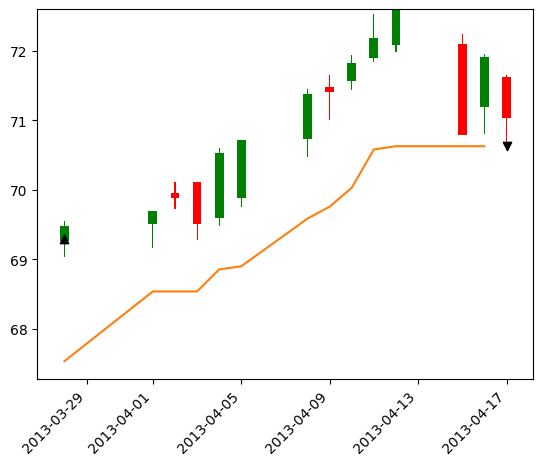

trade 80
entry: [72.5999984741211]
cost_basis: 72.5999984741211
exit: 74.07100334167481
returns: 0.02026177546102937
21


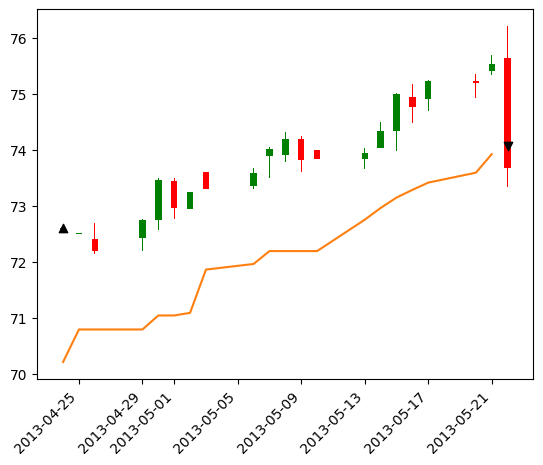

trade 81
entry: [66.93000030517578]
cost_basis: 66.93000030517578
exit: 66.6500015258789
returns: -0.004183457015093161
11


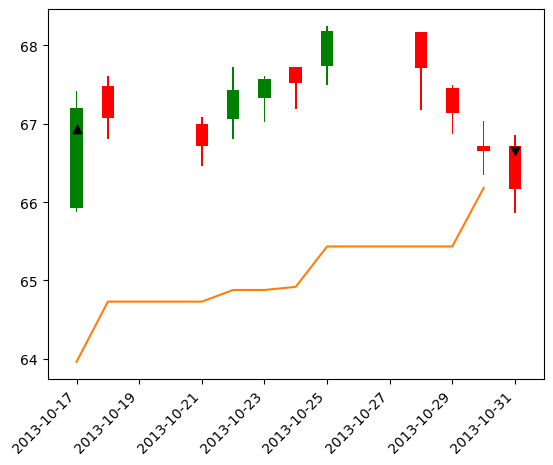

trade 82
entry: [65.30000305175781]
cost_basis: 65.30000305175781
exit: 67.75
returns: 0.03751909393174578
26


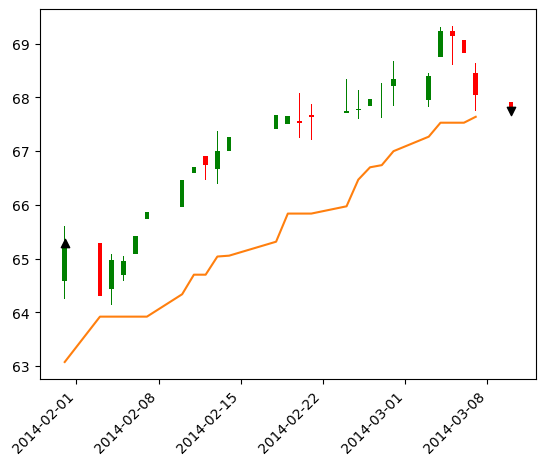

trade 83
entry: [69.23999786376953]
cost_basis: 69.23999786376953
exit: 70.80000305175781
returns: 0.022530404912166648
22


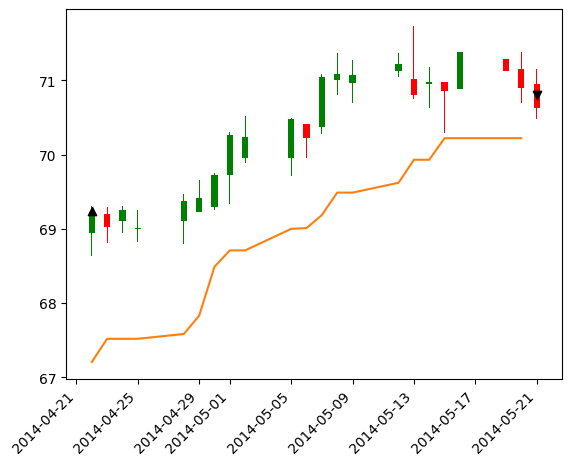

trade 84
entry: [71.37999725341797]
cost_basis: 71.37999725341797
exit: 71.35700302124023
returns: -0.0003221383169307443
11


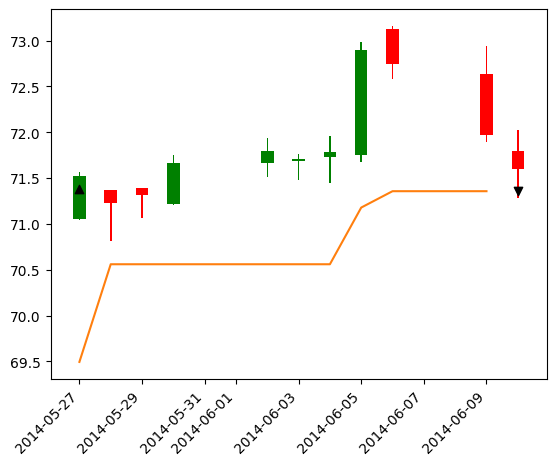

trade 85
entry: [72.9000015258789]
cost_basis: 72.9000015258789
exit: 72.43000030517578
returns: -0.0064472045386210096
9


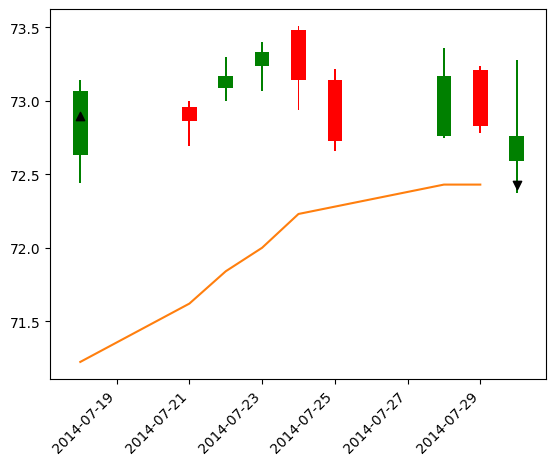

trade 86
entry: [73.33000183105469]
cost_basis: 73.33000183105469
exit: 73.77999877929688
returns: 0.006136600804660246
19


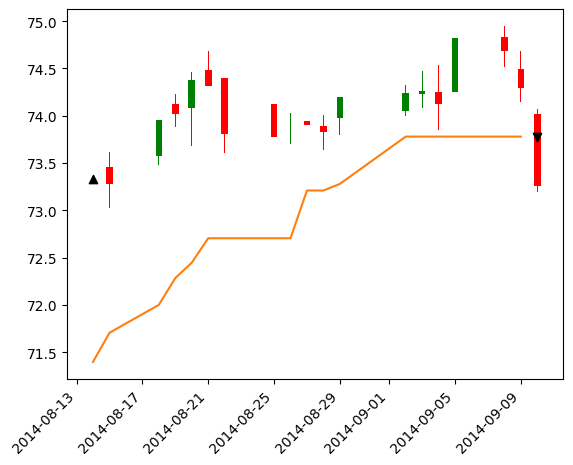

trade 87
entry: [74.81999969482422]
cost_basis: 74.81999969482422
exit: 74.9800033569336
returns: 0.0021385146052124815
11


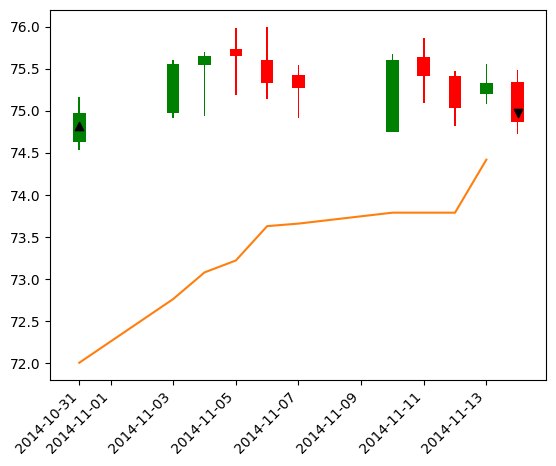

trade 88
entry: [75.6500015258789]
cost_basis: 75.6500015258789
exit: 76.66000366210938
returns: 0.013350986329920428
15


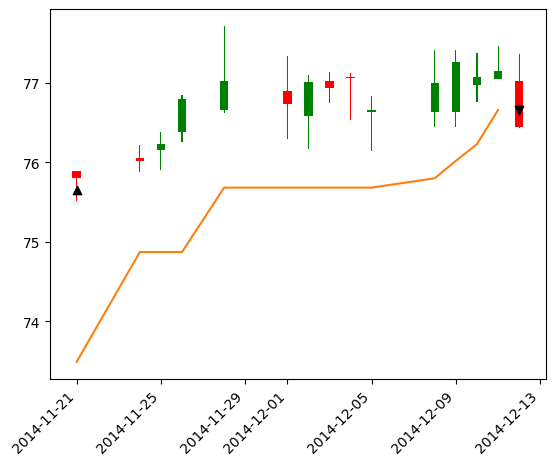

trade 89
entry: [77.26000213623047]
cost_basis: 77.26000213623047
exit: 80.91999816894531
returns: 0.0473724557535123
30


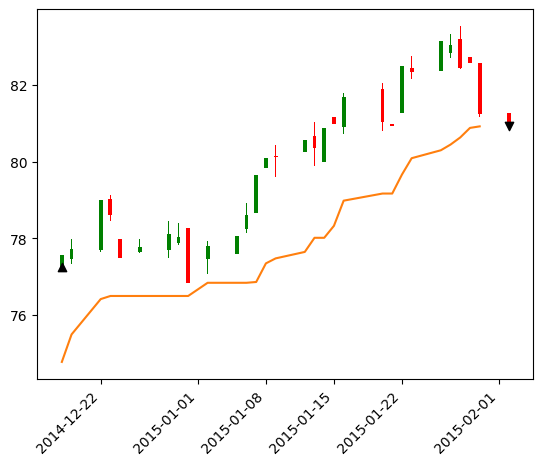

trade 90
entry: [75.9800033569336]
cost_basis: 75.9800033569336
exit: 74.75
returns: -0.01618851411673897
5


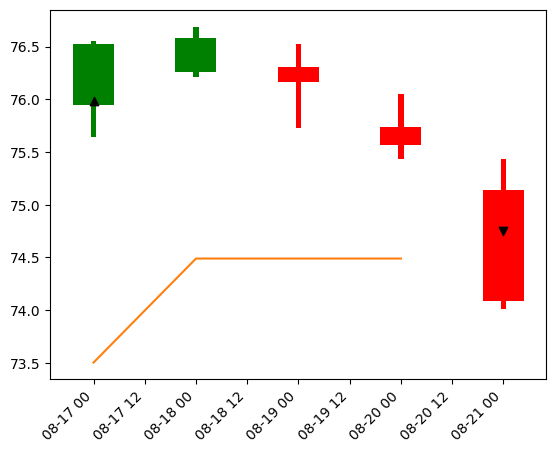

trade 91
entry: [76.58000183105469]
cost_basis: 76.58000183105469
exit: 75.36000061035156
returns: -0.01593106805344043
8


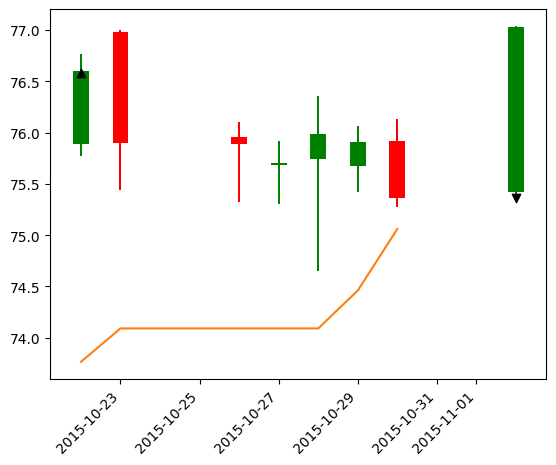

trade 92
entry: [75.98999786376953]
cost_basis: 75.98999786376953
exit: 77.12999725341797
returns: 0.015001966333676734
25


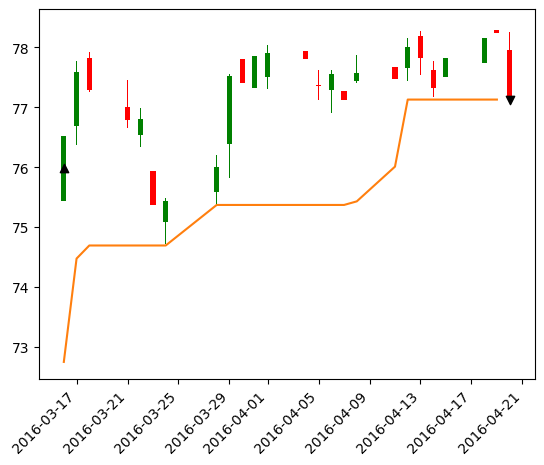

trade 93
entry: [78.23999786376953]
cost_basis: 78.23999786376953
exit: 77.72050056457519
returns: -0.006639791837659346
10


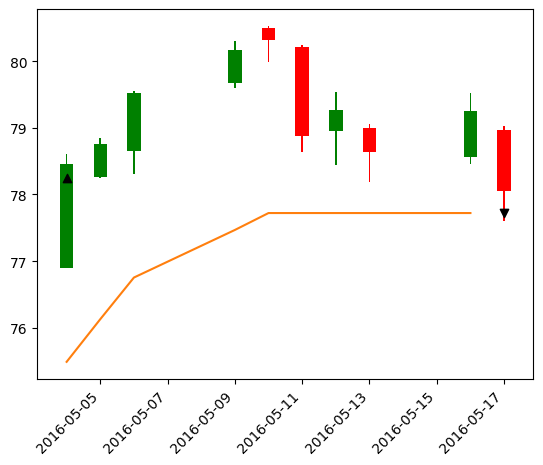

trade 94
entry: [80.30999755859375]
cost_basis: 80.30999755859375
exit: 78.61000061035156
returns: -0.021167936744137972
5


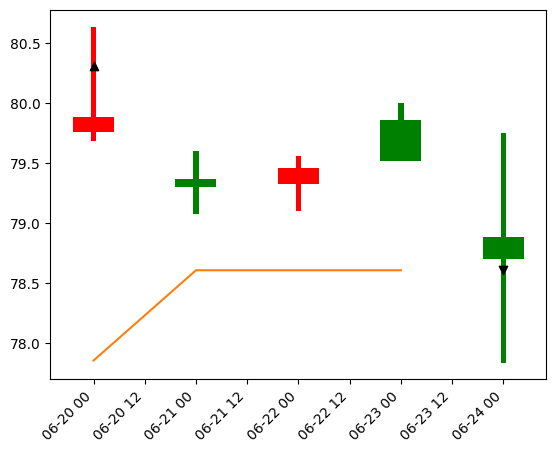

trade 95
entry: [80.30999755859375]
cost_basis: 80.30999755859375
exit: 83.56999969482422
returns: 0.040592731108626774
21


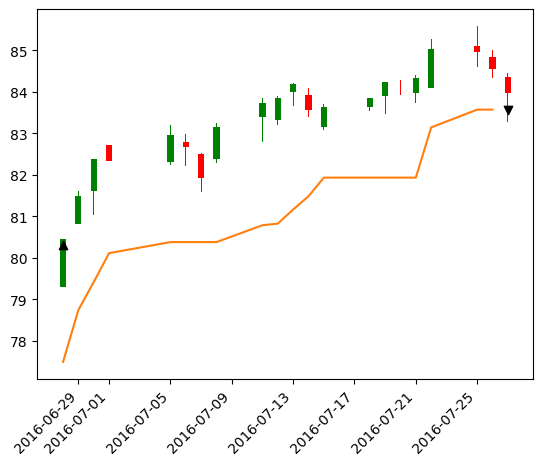

trade 96
entry: [85.02999877929688]
cost_basis: 85.02999877929688
exit: 83.95999908447266
returns: -0.012583790546692829
4


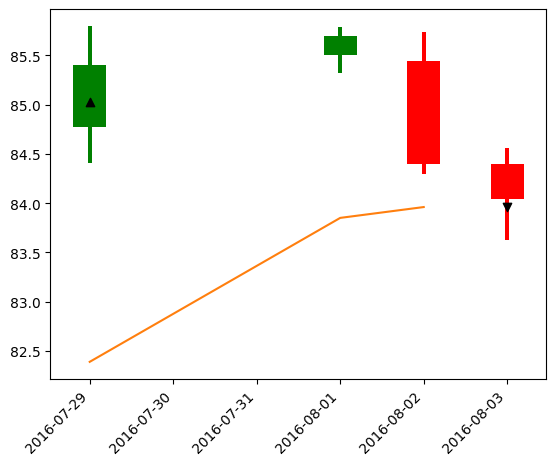

trade 97
entry: [78.38999938964844]
cost_basis: 78.38999938964844
exit: 76.83000183105469
returns: -0.01990046652302629
11


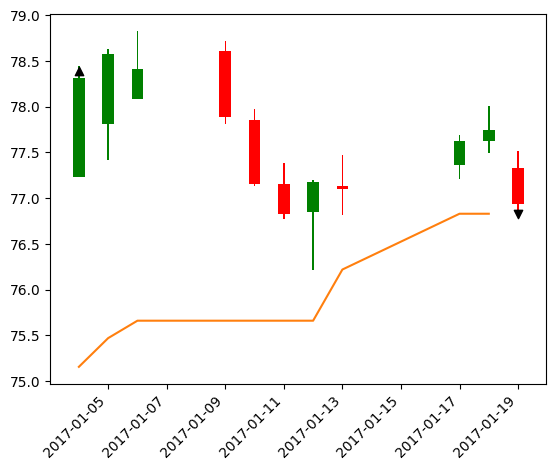

trade 98
entry: [78.58000183105469]
cost_basis: 78.58000183105469
exit: 79.2699966430664
returns: 0.008780794043441138
16


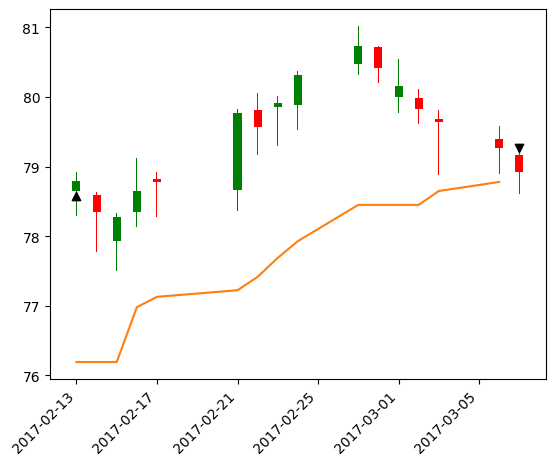

trade 99
entry: [80.7300033569336]
cost_basis: 80.7300033569336
exit: 79.79000091552734
returns: -0.011643780531634486
8


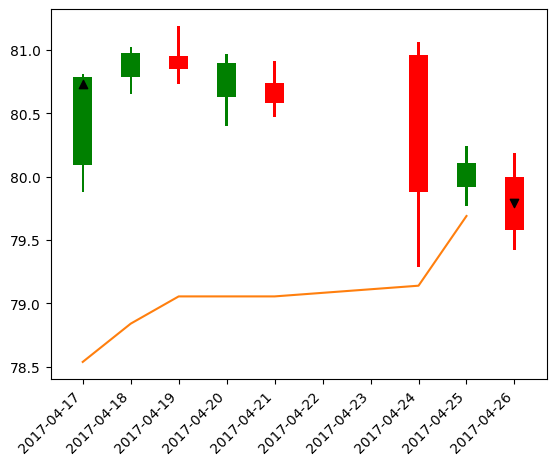

trade 100
entry: [80.9800033569336]
cost_basis: 80.9800033569336
exit: 80.69999694824219
returns: -0.003457722858533715
10


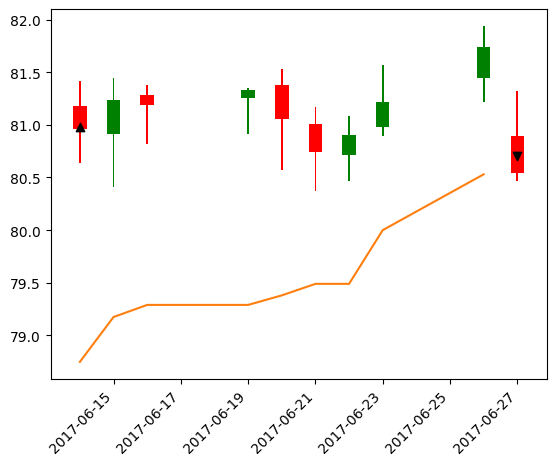

trade 101
entry: [81.73999786376953]
cost_basis: 81.73999786376953
exit: 81.04000091552734
returns: -0.008563701572500951
9


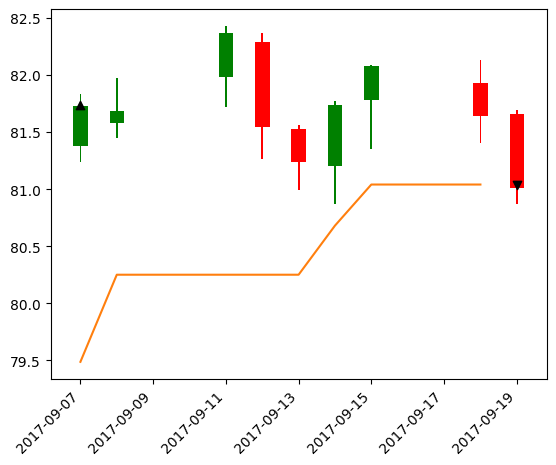

trade 102
entry: [82.37000274658203]
cost_basis: 82.37000274658203
exit: 81.97000122070312
returns: -0.004856155305828304
14


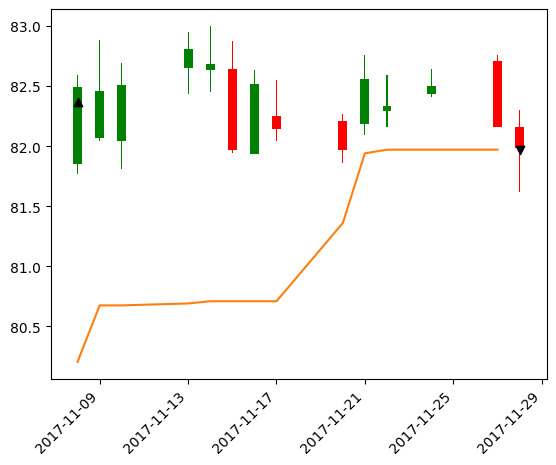

trade 103
entry: [82.80999755859375]
cost_basis: 82.80999755859375
exit: 80.9800033569336
returns: -0.022098710972250784
2


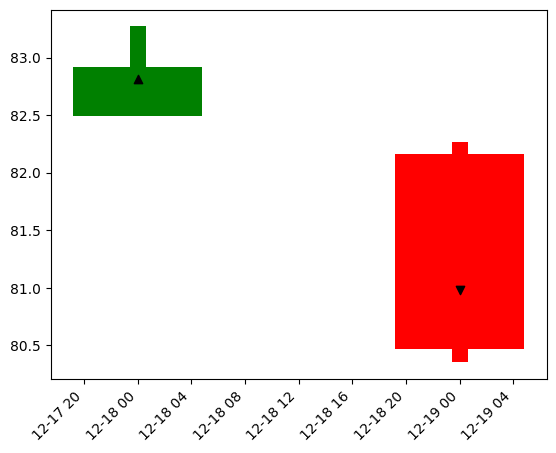

trade 104
entry: [76.4800033569336]
cost_basis: 76.4800033569336
exit: 75.91000366210938
returns: -0.0074529245528928605
8


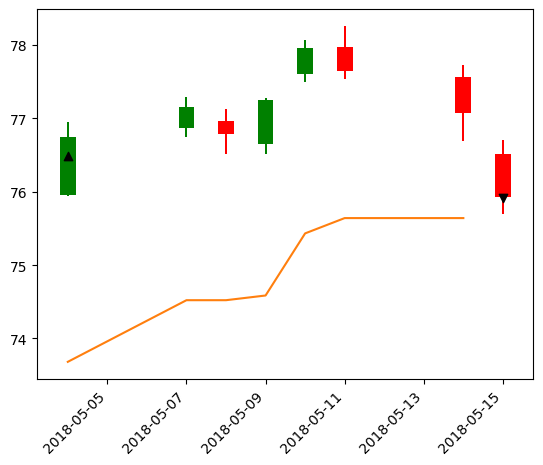

trade 105
entry: [77.95999908447266]
cost_basis: 77.95999908447266
exit: 78.19000244140625
returns: 0.002950273981973451
11


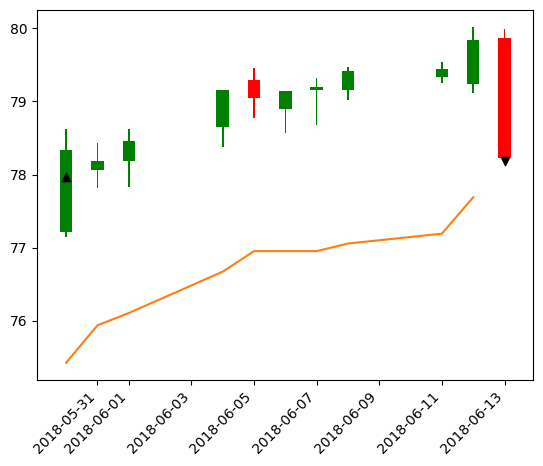

trade 106
entry: [79.83999633789062]
cost_basis: 79.83999633789062
exit: 80.5199966430664
returns: 0.008517038281138615
20


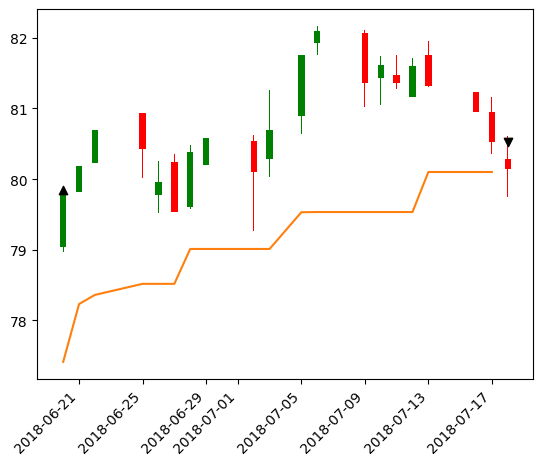

trade 107
entry: [82.08999633789062]
cost_basis: 82.08999633789062
exit: 82.08999633789062
returns: 0.0
23


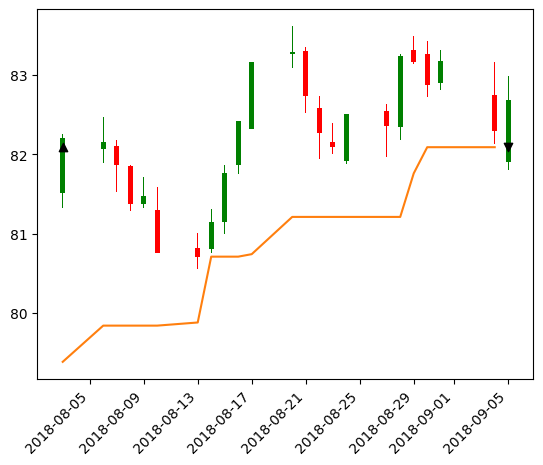

trade 108
entry: [82.2300033569336]
cost_basis: 82.2300033569336
exit: 80.16000366210938
returns: -0.025173289679182257
5


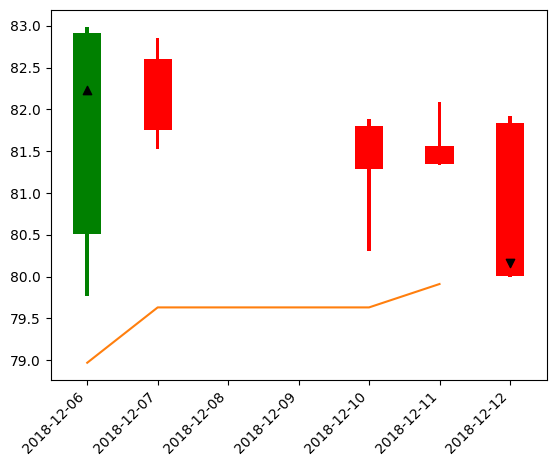

trade 109
entry: [82.91999816894531]
cost_basis: 82.91999816894531
exit: 83.87000274658203
returns: 0.01145688131469965
20


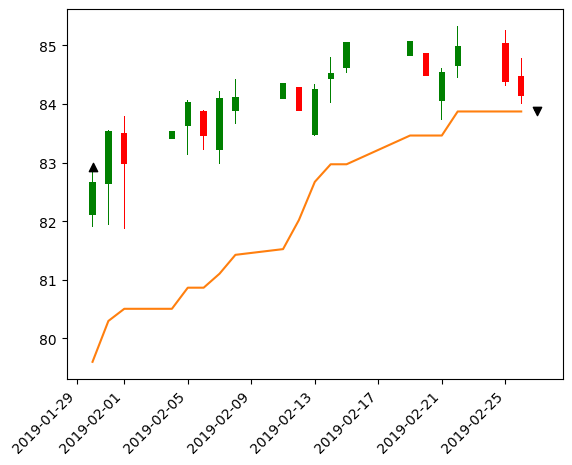

trade 110
entry: [85.06999969482422]
cost_basis: 85.06999969482422
exit: 87.01000213623047
returns: 0.022804777810811284
27


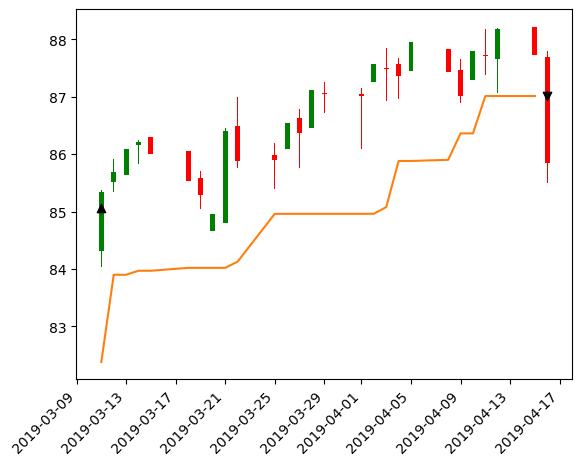

trade 111
entry: [88.16999816894531]
cost_basis: 88.16999816894531
exit: 86.68000030517578
returns: -0.01689914817639555
9


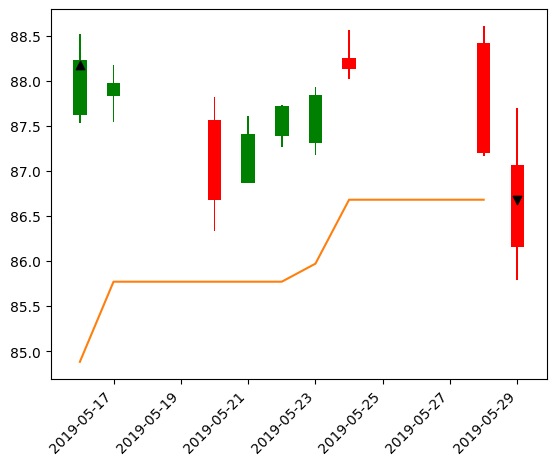

trade 112
entry: [88.2300033569336]
cost_basis: 88.2300033569336
exit: 89.02999877929688
returns: 0.009067158471329847
15


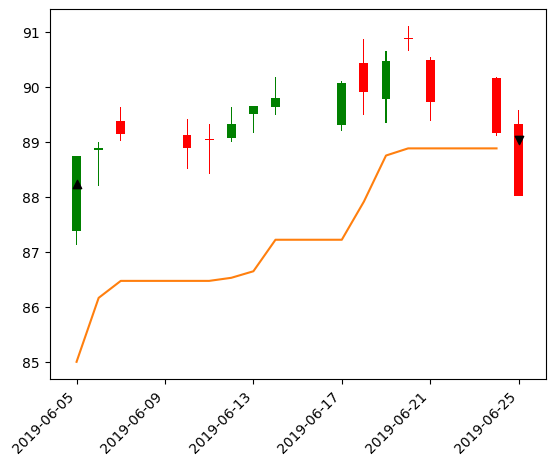

trade 113
entry: [90.87000274658205]
cost_basis: 90.87000274658205
exit: 88.9800033569336
returns: -0.020798936200313273
6


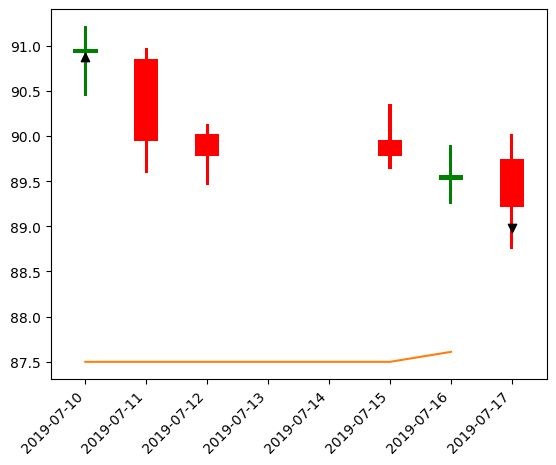

trade 114
entry: [90.95999908447266]
cost_basis: 90.95999908447266
exit: 91.4000015258789
returns: 0.004837318006100999
23


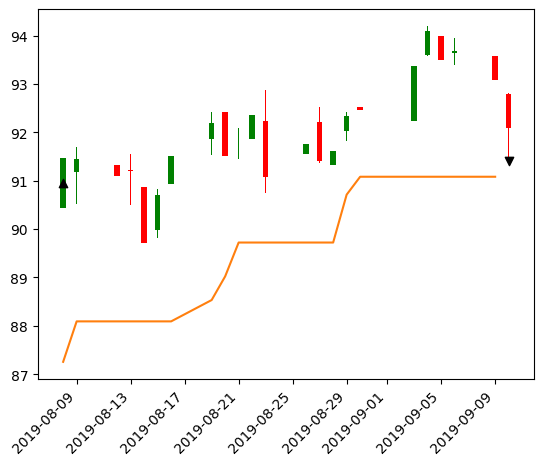

trade 115
entry: [94.08999633789062]
cost_basis: 94.08999633789062
exit: 92.93000030517578
returns: -0.012328579847629414
7


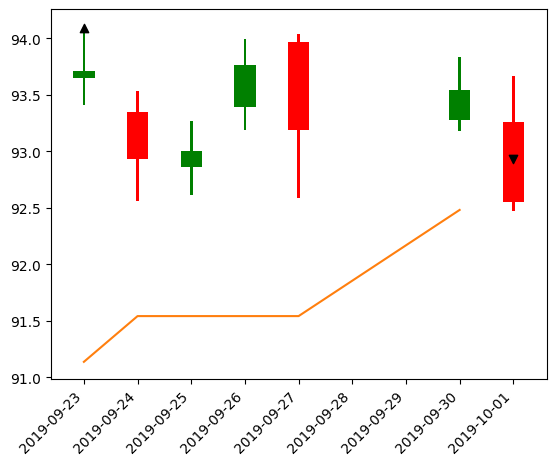

trade 116
entry: [94.08999633789062]
cost_basis: 94.08999633789062
exit: 93.58000183105467
returns: -0.005420284054475765
11


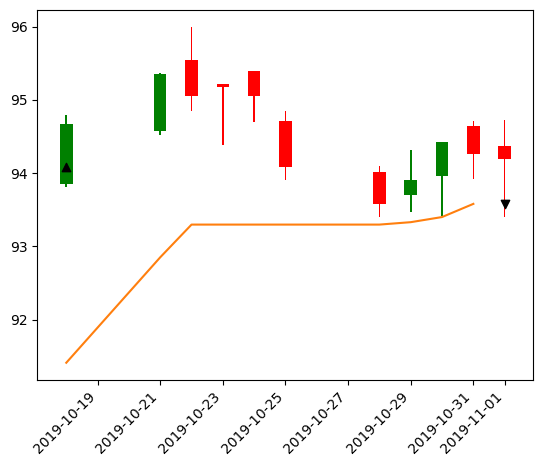

trade 117
entry: [94.41999816894533]
cost_basis: 94.41999816894533
exit: 95.08000183105467
returns: 0.006990083402971525
12


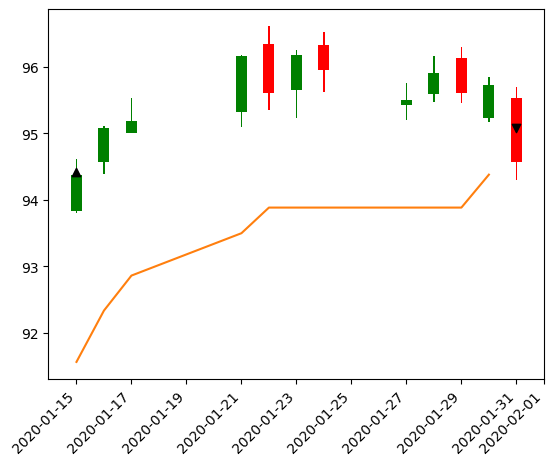

trade 118
entry: [96.18000030517578]
cost_basis: 96.18000030517578
exit: 97.79949798583984
returns: 0.016838195836197174
15


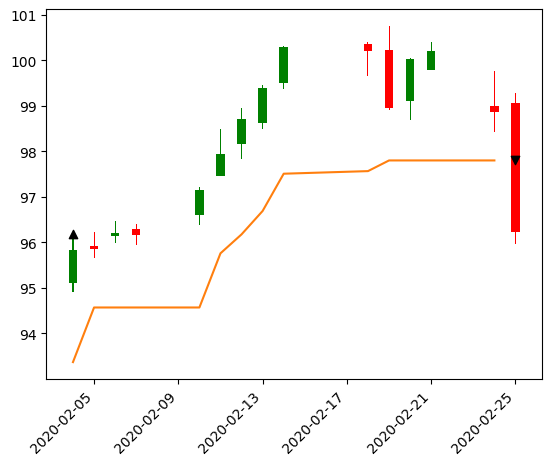

trade 119
entry: [79.91999816894531]
cost_basis: 79.91999816894531
exit: 80.32750015258789
returns: 0.005098873786022173
7


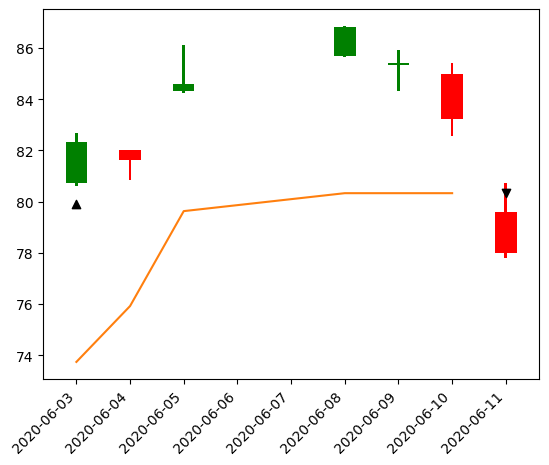

trade 120
entry: [83.0199966430664]
cost_basis: 83.0199966430664
exit: 81.30999755859375
returns: -0.020597436203527848
6


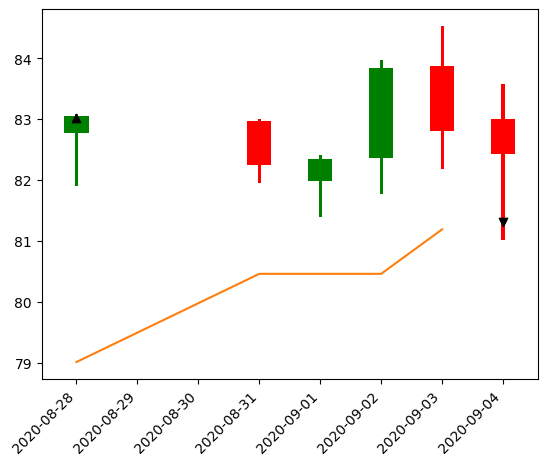

trade 121
entry: [83.83999633789062]
cost_basis: 83.83999633789062
exit: 80.58000183105469
returns: -0.03888352396507222
5


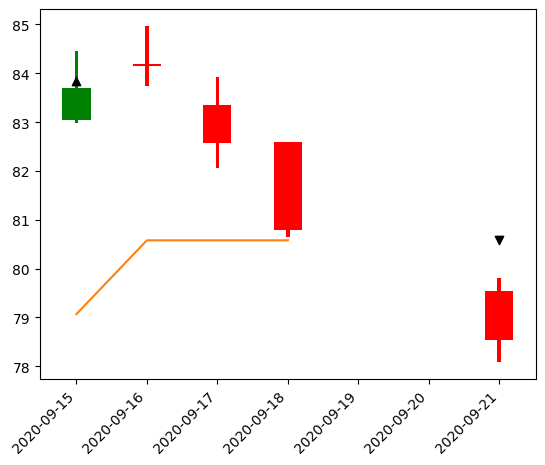

trade 122
entry: [84.1500015258789]
cost_basis: 84.1500015258789
exit: 81.37999725341797
returns: -0.032917459563076415
6


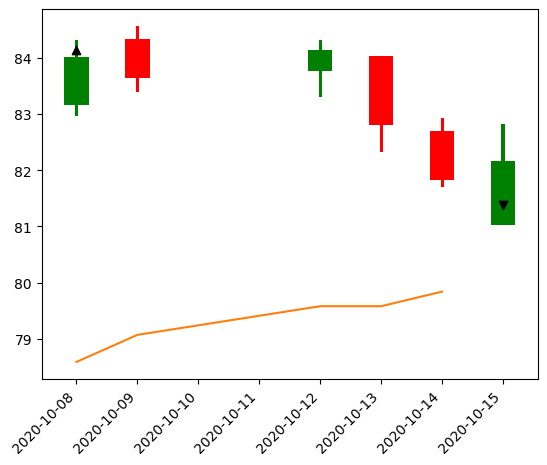

trade 123
entry: [84.1500015258789]
cost_basis: 84.1500015258789
exit: 84.8499984741211
returns: 0.008318442490187185
15


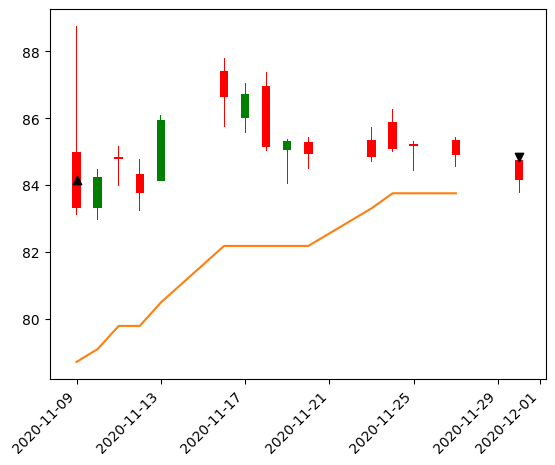

trade 124
entry: [86.70999908447266]
cost_basis: 86.70999908447266
exit: 88.23999786376953
returns: 0.01764500975033288
20


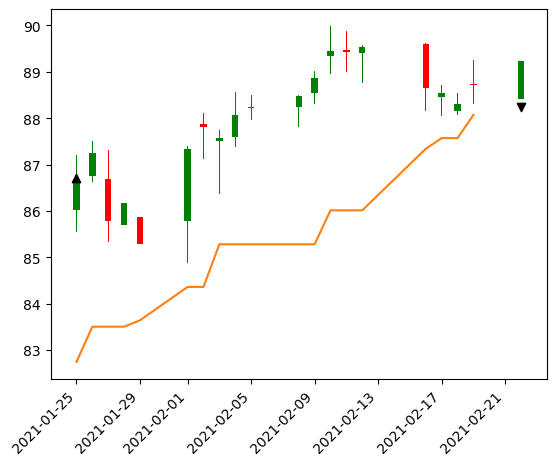

trade 125
entry: [89.54000091552734]
cost_basis: 89.54000091552734
exit: 88.30000305175781
returns: -0.013848535303672308
3


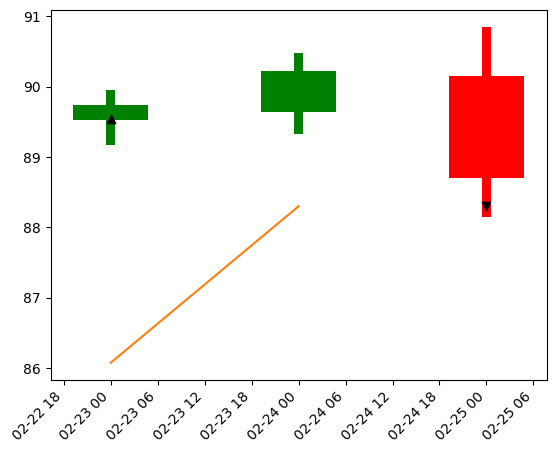

trade 126
entry: [90.22000122070312]
cost_basis: 90.22000122070312
exit: 89.37999725341797
returns: -0.009310617999552824
10


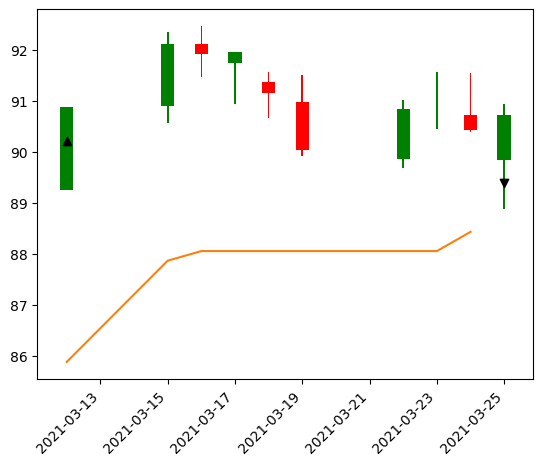

trade 127
entry: [92.12000274658205]
cost_basis: 92.12000274658205
exit: 97.61000061035156
returns: 0.05959615393056655
28


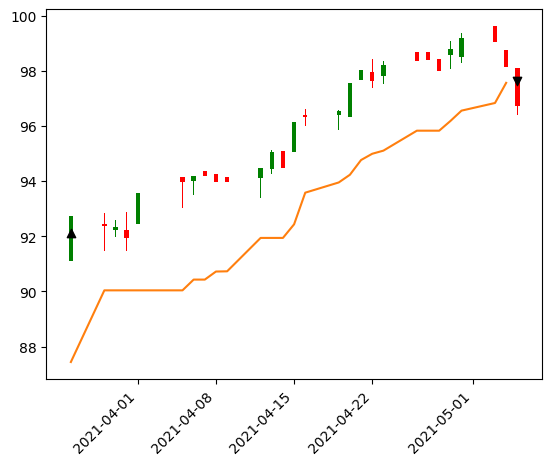

trade 128
entry: [99.19000244140624]
cost_basis: 99.19000244140624
exit: 96.70999908447266
returns: -0.025002553643433706
3


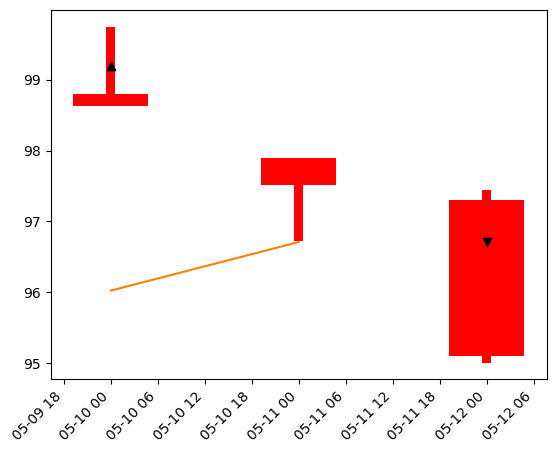

trade 129
entry: [99.19000244140624]
cost_basis: 99.19000244140624
exit: 102.79000091552734
returns: 0.03629396497139626
18


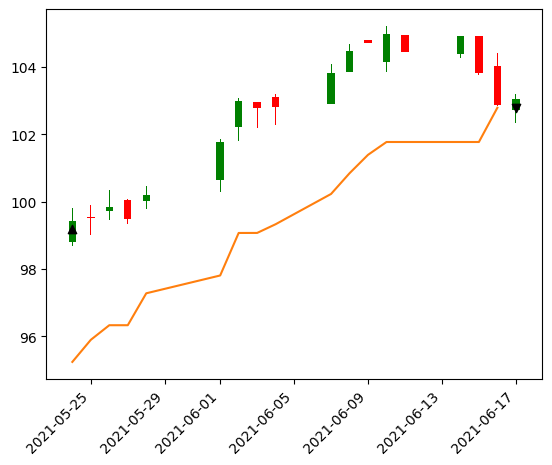

trade 130
entry: [104.97000122070312]
cost_basis: 104.97000122070312
exit: 106.2699966430664
returns: 0.012384447053877756
23


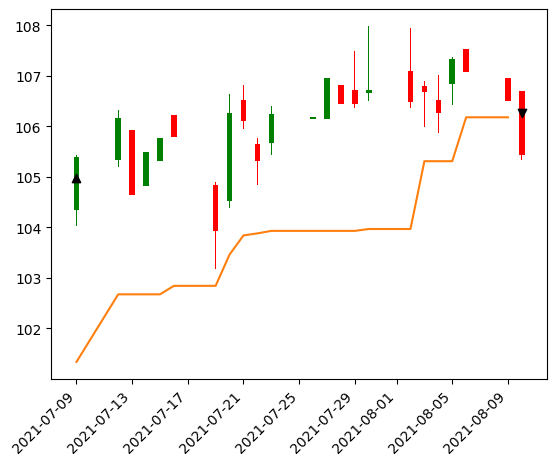

trade 131
entry: [107.33999633789062]
cost_basis: 107.33999633789062
exit: 105.43000030517578
returns: -0.01779388949019949
4


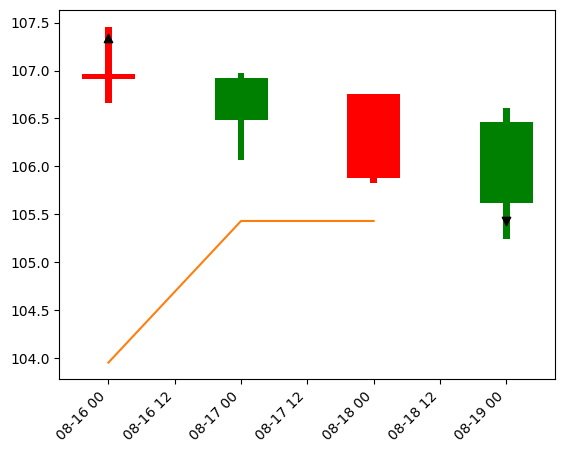

trade 132
entry: [107.33999633789062]
cost_basis: 107.33999633789062
exit: 105.87999725341795
returns: -0.013601631584528907
4


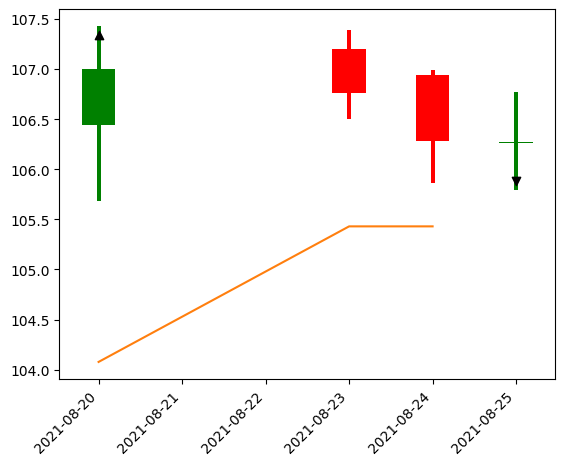

trade 133
entry: [107.33999633789062]
cost_basis: 107.33999633789062
exit: 108.06200065612792
returns: 0.006726330751535821
10


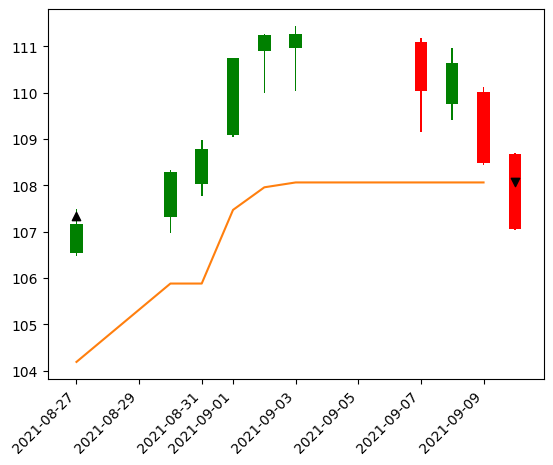

trade 134
entry: [111.2699966430664]
cost_basis: 111.2699966430664
exit: 109.69000244140624
returns: -0.014199642754807479
2


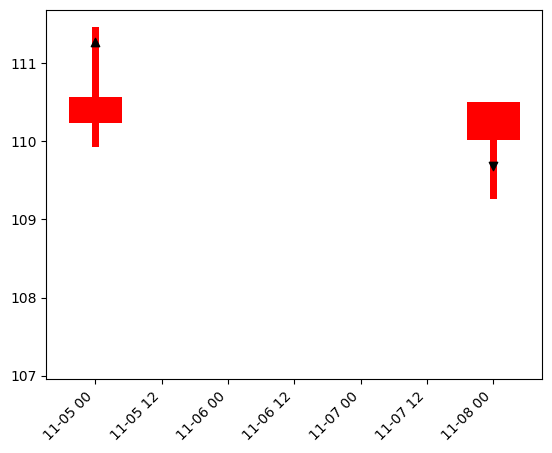

trade 135
entry: [110.95999908447266]
cost_basis: 110.95999908447266
exit: 109.13999938964844
returns: -0.016402304522719693
2


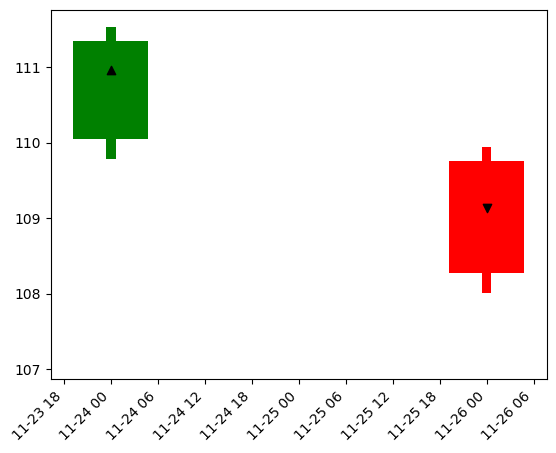

trade 136
entry: [111.3499984741211]
cost_basis: 111.3499984741211
exit: 109.88999938964844
returns: -0.013111801566948161
10


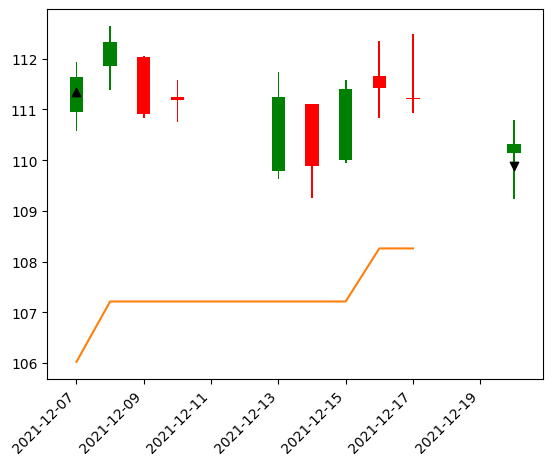

trade 137
entry: [112.33999633789062]
cost_basis: 112.33999633789062
exit: 112.19799728393555
returns: -0.0012640115594091496
10


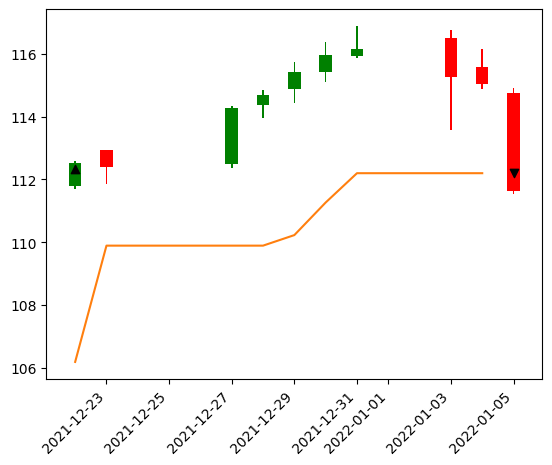

trade 138
entry: [110.33999633789062]
cost_basis: 110.33999633789062
exit: 108.22000122070312
returns: -0.01921329696890244
7


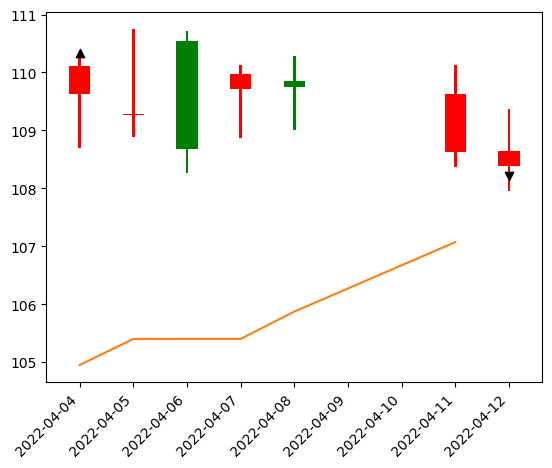

trade 139
entry: [110.5500030517578]
cost_basis: 110.5500030517578
exit: 108.11000061035156
returns: -0.022071482352323993
5


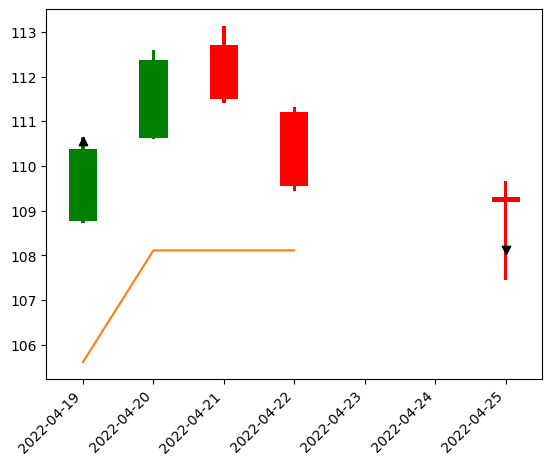

trade 140
entry: [100.36000061035156]
cost_basis: 100.36000061035156
exit: 99.33999633789062
returns: -0.010163454227358084
17


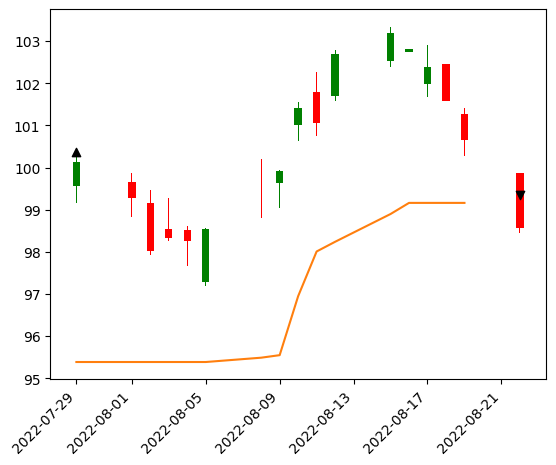

trade 141
entry: [89.16999816894531]
cost_basis: 89.16999816894531
exit: 86.37000274658203
returns: -0.031400644609841634
3


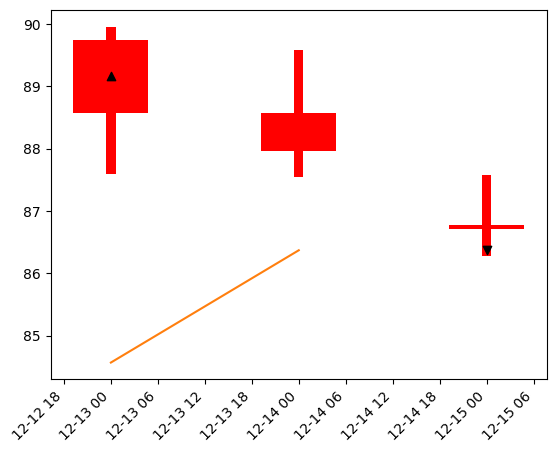

trade 142
entry: [89.16999816894531]
cost_basis: 89.16999816894531
exit: 90.8000030517578
returns: 0.018279745612691488
22


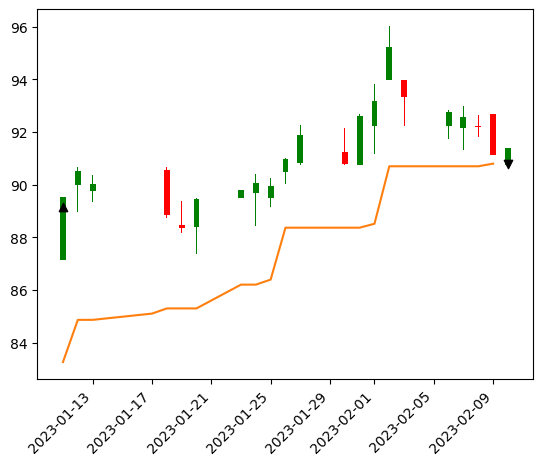

In [101]:
def plot_candle(df, show=False):
    #define width of candlestick elements
    width = .4
    width2 = .05

    #define up and down t.df
    up = df[df.close>=df.open].copy()
    down = df[df.close<df.open].copy()

    #define colors to use
    col1 = 'green'
    col2 = 'red'

    #plot up t.df
    plt.bar(up.index,up.close-up.open,width,bottom=up.open,color=col1)
    plt.bar(up.index,up.high-up.close,width2,bottom=up.close,color=col1)
    plt.bar(up.index,up.low-up.open,width2,bottom=up.open,color=col1)

    #plot down t.df
    plt.bar(down.index,down.close-down.open,width,bottom=down.open,color=col2)
    plt.bar(down.index,down.high-down.open,width2,bottom=down.open,color=col2)
    plt.bar(down.index,down.low-down.close,width2,bottom=down.close,color=col2)

    #rotate x-axis tick labels
    plt.xticks(rotation=45, ha='right')

    if show:
        #display candlestick chart
        plt.show()


for i in range(len(tl.list)):
    t = tl.list[i]

    print(f'trade {i}')
    print(f'entry: {t.entry_price}')
    print(f'cost_basis: {t.cost_basis}')
    print(f'exit: {t.exit_price}')
    print(f'returns: {t.returns}')
    
    
    plot_candle(t.df)
    print(len(t.df))
    
    
    plt.plot(t.df['stop_loss'], color='C1')
    plt.scatter(t.df.index, t.df['entry_price'], marker='^', color='black')
    plt.scatter(t.df.index, t.df['exit_price'], marker='v', color='black')
    plt.show()



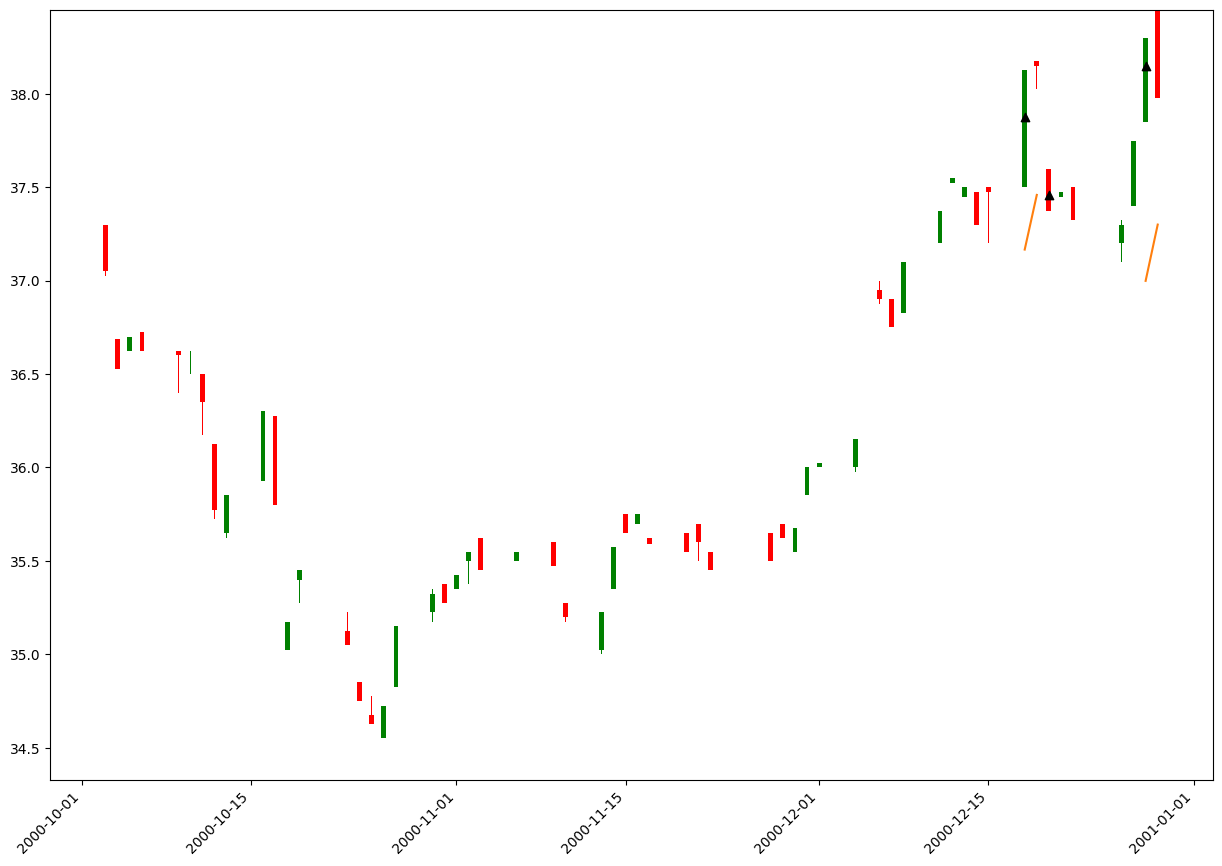

In [102]:
import datetime as dt
mask = (df.index >= pd.to_datetime(dt.date(2000, 1, 1))) & (df.index <= pd.to_datetime(dt.date(2001, 1, 1)))
df1 = df.loc[mask]
    
plt.figure(figsize=(15,10)) 
plot_candle(df1)

plt.plot(df1['stop_loss'], color='C1')
plt.scatter(df1.index, df1['entry_price'], marker='^', color='black')
plt.scatter(df1.index, df1['exit_price'], marker='^', color='black')
plt.show()

<Axes: >

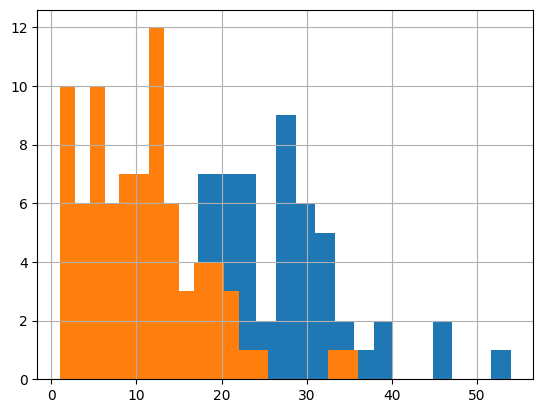

In [103]:
tl.win_records['time_in_trade'].hist(bins=20)
tl.loss_records['time_in_trade'].hist(bins=20)

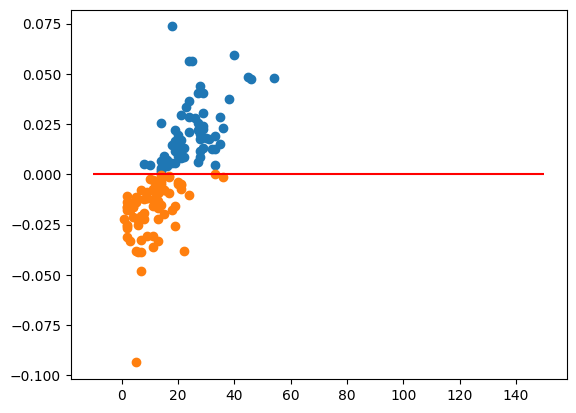

In [104]:
plt.scatter(tl.win_records['time_in_trade'], tl.win_records['returns'])
plt.scatter(tl.loss_records['time_in_trade'], tl.loss_records['returns'])
plt.hlines(0, -10, 150, color='red')